# Student performance prediction

By Emil Schallwig 

Assignment Nr. 4, Education education

## Introduction

In this project we will investigate student performance in secondary education, i.e. middle and high school. As performance in this section can be deterministic for the future of the student, e.g. university can only be an option if grades are sufficiently good, it is vital to keep track of performances at this stage. By finding students that may to struggle, appropriate authorities can initiate suitable meassures to optimally assist the student. 
On the other hand, identifying superb students at an early stage can be beneficial since they could be offered programs in which their talent can be challenged further.
Both cases not only help the individuales, but also the nation or the general world since the educational state of the world population would rise.

### Importing libraries and data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import hp, fmin, tpe, STATUS_OK
from tabpfn import TabPFNClassifier, TabPFNRegressor
import tqdm

### Understanding the data

In [ ]:
mat = pd.read_csv("data_Schallwig/student-mat.csv", sep=";")
por = pd.read_csv("data_Schallwig/student-por.csv", sep=";")
# concat the two datasets on the 'school' and 'student' columns
mat["subject"] = "math"
por["subject"] = "portuguese"

print(por.shape, mat.shape)


(649, 34) (395, 34)


The dataset comes from the UCI Repository but was first introduced by a paper from Cortez and Silva (2008). The data records student attributes/performance from the school year 2005-2006. The dataset consists of two subsets: performance for math (395 data entries) and performance for the nativ language (649 entries) of the students, portugeuse. Both sets have the same 33 columns. The attributes range from demographic and social related features to school and student grades. The dataset containing math results has 395 entries, whereas the dataset recording nativ language performance contains 649 data points. There are 382 students that occur in both datasets.
The dataset has one target variable, G3, however, it contains two additional variables that are highly correlated to this final grade, namely G1 and G2, as these describe the students performance during the school period.

| #  | Attribute   | Description | Cardinality |
|----|-------------|-------------|-------------|
| 1  | `school`    | Student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira) | 2 |
| 2  | `sex`       | Student's sex (binary: 'F' - female or 'M' - male) | 2 |
| 3  | `age`       | Student's age (numeric: from 15 to 22) | - |
| 4  | `address`   | Student's home address type (binary: 'U' - urban or 'R' - rural) | 2 |
| 5  | `famsize`   | Family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3) | 2 |
| 6  | `Pstatus`   | Parent's cohabitation status (binary: 'T' - living together or 'A' - apart) | 2 |
| 7  | `Medu`      | Mother's education (0 - none, 1 - primary, 2 - 5th–9th grade, 3 - secondary, 4 - higher) | 5 |
| 8  | `Fedu`      | Father's education (same as above) | 5 |
| 9  | `Mjob`      | Mother's job (nominal: 'teacher', 'health', 'services', 'at_home', 'other') | 5 |
| 10 | `Fjob`      | Father's job (same as above) | 5 |
| 11 | `reason`    | Reason to choose school ('home', 'reputation', 'course', 'other') | 4 |
| 12 | `guardian`  | Student's guardian ('mother', 'father', 'other') | 3 |
| 13 | `traveltime`| Home to school travel time (1 - <15 min, 2 - 15–30 min, 3 - 30–60 min, 4 - >1 hour) | 4 |
| 14 | `studytime` | Weekly study time (1 - <2 hrs, 2 - 2–5 hrs, 3 - 5–10 hrs, 4 - >10 hrs) | 4 |
| 15 | `failures`  | Number of past class failures (numeric: n if 1≤n<3, else 4) | 4 |
| 16 | `schoolsup` | Extra educational support (binary: yes or no) | 2 |
| 17 | `famsup`    | Family educational support (binary: yes or no) | 2 |
| 18 | `paid`      | Extra paid classes (binary: yes or no) | 2 |
| 19 | `activities`| Extra-curricular activities (binary: yes or no) | 2 |
| 20 | `nursery`   | Attended nursery school (binary: yes or no) | 2 |
| 21 | `higher`    | Wants to take higher education (binary: yes or no) | 2 |
| 22 | `internet`  | Internet access at home (binary: yes or no) | 2 |
| 23 | `romantic`  | With a romantic relationship (binary: yes or no) | 2 |
| 24 | `famrel`    | Quality of family relationships (1 - very bad to 5 - excellent) | 5 |
| 25 | `freetime`  | Free time after school (1 - very low to 5 - very high) | 5 |
| 26 | `goout`     | Going out with friends (1 - very low to 5 - very high) | 5 |
| 27 | `Dalc`      | Workday alcohol consumption (1 - very low to 5 - very high) | 5 |
| 28 | `Walc`      | Weekend alcohol consumption (1 - very low to 5 - very high) | 5 |
| 29 | `health`    | Current health status (1 - very bad to 5 - very good) | 5 |
| 30 | `absences`  | Number of school absences (numeric: 0 to 93) | - |
| 31 | `G1`        | First period grade (numeric: 0 to 20; **Target**) | 20 |
| 32 | `G2`        | Second period grade (numeric: 0 to 20) | 20 |
| 33 | `G3`        | Final grade (numeric: 0 to 20) | 20 |


### Aim 

Although the dataset and Cortez and Silva (2008) identify G3 as the primary target variable, we contend that predicting G1—the first-period grade—is more important, as performance during this period can be decisive for subsequent results. The authors themselves also acknowledge this point.

Understanding student performance at the earliest stage, rather than at the end of the academic year, enables schools to respond promptly to students’ needs, such as providing additional support, instead of relying on the assumption that students will resolve difficulties independently.

There are several ways to pursue this objective using machine learning, including binary classification (pass or fail), five-level classification (e.g., A, B, C), or standard regression (0–20). While five-level classification may appear more suitable—since the aim is to assess general performance rather than precise scores—regression offers more practical performance metrics, as it quantifies error in terms of the distance between actual and predicted values. For instance, predicting A when the actual grade is D would simply be recorded as a misclassification, ignoring the severity of the error. In contrast, distance-based metrics such as RMSE, MAE, or standard deviation allow for an analysis of how far forecasted values deviate from actual outcomes.

Therefore, this project focuses on regression.

## Exploratory data analysis

We aim to create one model that can predict the performance in any school subject based on the given attributes. As such we merge the two datasets. To be able to discern the performance between subjects, we add a new attribute called "subject" which is a categorical encoding (math, portuguese).

### Basic pre-processing / formatting

In [3]:
merged = pd.concat([mat, por], ignore_index=True)
# merged.drop_duplicates(subset=["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet", "subject"], inplace=True)
print(f"Expected shape {por.shape[0] + mat.shape[0], 34}")
merged.head()

Expected shape (1044, 34)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,math
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,math
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,math
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,math
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,math


The dataset is very messy. Many attributes are encoded as categorical values. For some EDA and machine learning methods they need to be numerical, so lets change it

In [4]:
merged_num = merged.copy()
merged_num["school"] = np.where(merged_num["school"] == "GP", "0", "1")
merged_num["sex"] = np.where(merged_num["sex"] == "F", "0", "1")
merged_num["address"] = np.where(merged_num["address"] == "U", "0", "1")
merged_num["famsize"] = np.where(merged_num["famsize"] == "LE3", "0", "1")
merged_num["Pstatus"] = np.where(merged_num["Pstatus"] == "A", "0", "1")
merged_num["subject"] = np.where(merged_num["subject"] == "math", "0", "1")

# Binary features (yes/no)
merged_num["schoolsup"] = np.where(merged_num["schoolsup"] == "yes", "1", "0")
merged_num["famsup"] = np.where(merged_num["famsup"] == "yes", "1", "0")
merged_num["paid"] = np.where(merged_num["paid"] == "yes", "1", "0")
merged_num["activities"] = np.where(merged_num["activities"] == "yes", "1", "0")
merged_num["nursery"] = np.where(merged_num["nursery"] == "yes", "1", "0")
merged_num["higher"] = np.where(merged_num["higher"] == "yes", "1", "0")
merged_num["internet"] = np.where(merged_num["internet"] == "yes", "1", "0")
merged_num["romantic"] = np.where(merged_num["romantic"] == "yes", "1", "0")

# Nominal features – use one-hot encoding
# Mjob and Fjob dummy is "at_home"
# Reason "course" is dummy
# For guardian the "father" is dummy
merged_num = pd.get_dummies(merged_num, columns=["Mjob", "Fjob", "reason", "guardian"], drop_first=False, dtype=int)

column_to_move = merged_num.pop("G1")
merged_num.insert(46, "G1", column_to_move)

column_to_move = merged_num.pop("G2")
merged_num.insert(46, "G2", column_to_move)

column_to_move = merged_num.pop("G3")
merged_num.insert(46, "G3", column_to_move)


merged_num.columns
merged_num


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,G1,G2,G3
0,0,0,18,0,1,0,4,4,2,2,...,1,0,0,0,0,1,0,5,6,6
1,0,0,17,0,1,1,1,1,1,2,...,1,0,0,0,1,0,0,5,5,6
2,0,0,15,0,0,1,1,1,1,2,...,0,0,1,0,0,1,0,7,8,10
3,0,0,15,0,1,1,4,2,1,3,...,0,1,0,0,0,1,0,15,14,15
4,0,0,16,0,1,1,3,3,1,2,...,0,1,0,0,1,0,0,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,1,0,19,1,1,1,2,3,1,3,...,1,0,0,0,0,1,0,10,11,10
1040,1,0,18,0,0,1,3,1,1,2,...,1,0,0,0,0,1,0,15,15,16
1041,1,0,18,0,1,1,1,1,2,2,...,1,0,0,0,0,1,0,11,12,9
1042,1,1,17,0,0,1,3,1,2,1,...,1,0,0,0,0,1,0,10,10,10


Formatting all columns to the right datatype for EDA

In [5]:
old_types = merged_num.dtypes
old_types

school               object
sex                  object
age                   int64
address              object
famsize              object
Pstatus              object
Medu                  int64
Fedu                  int64
traveltime            int64
studytime             int64
failures              int64
schoolsup            object
famsup               object
paid                 object
activities           object
nursery              object
higher               object
internet             object
romantic             object
famrel                int64
freetime              int64
goout                 int64
Dalc                  int64
Walc                  int64
health                int64
absences              int64
subject              object
Mjob_at_home          int64
Mjob_health           int64
Mjob_other            int64
Mjob_services         int64
Mjob_teacher          int64
Fjob_at_home          int64
Fjob_health           int64
Fjob_other            int64
Fjob_services       

In [6]:
# Automatically cast non-int64 columns to int
for col in merged_num.columns:
    if merged_num[col].dtype != "int64":
        merged_num[col] = merged_num[col].astype(int)


In [7]:
merged_num.dtypes

school               int64
sex                  int64
age                  int64
address              int64
famsize              int64
Pstatus              int64
Medu                 int64
Fedu                 int64
traveltime           int64
studytime            int64
failures             int64
schoolsup            int64
famsup               int64
paid                 int64
activities           int64
nursery              int64
higher               int64
internet             int64
romantic             int64
famrel               int64
freetime             int64
goout                int64
Dalc                 int64
Walc                 int64
health               int64
absences             int64
subject              int64
Mjob_at_home         int64
Mjob_health          int64
Mjob_other           int64
Mjob_services        int64
Mjob_teacher         int64
Fjob_at_home         int64
Fjob_health          int64
Fjob_other           int64
Fjob_services        int64
Fjob_teacher         int64
r

### Analysis

#### Correlation

<Axes: >

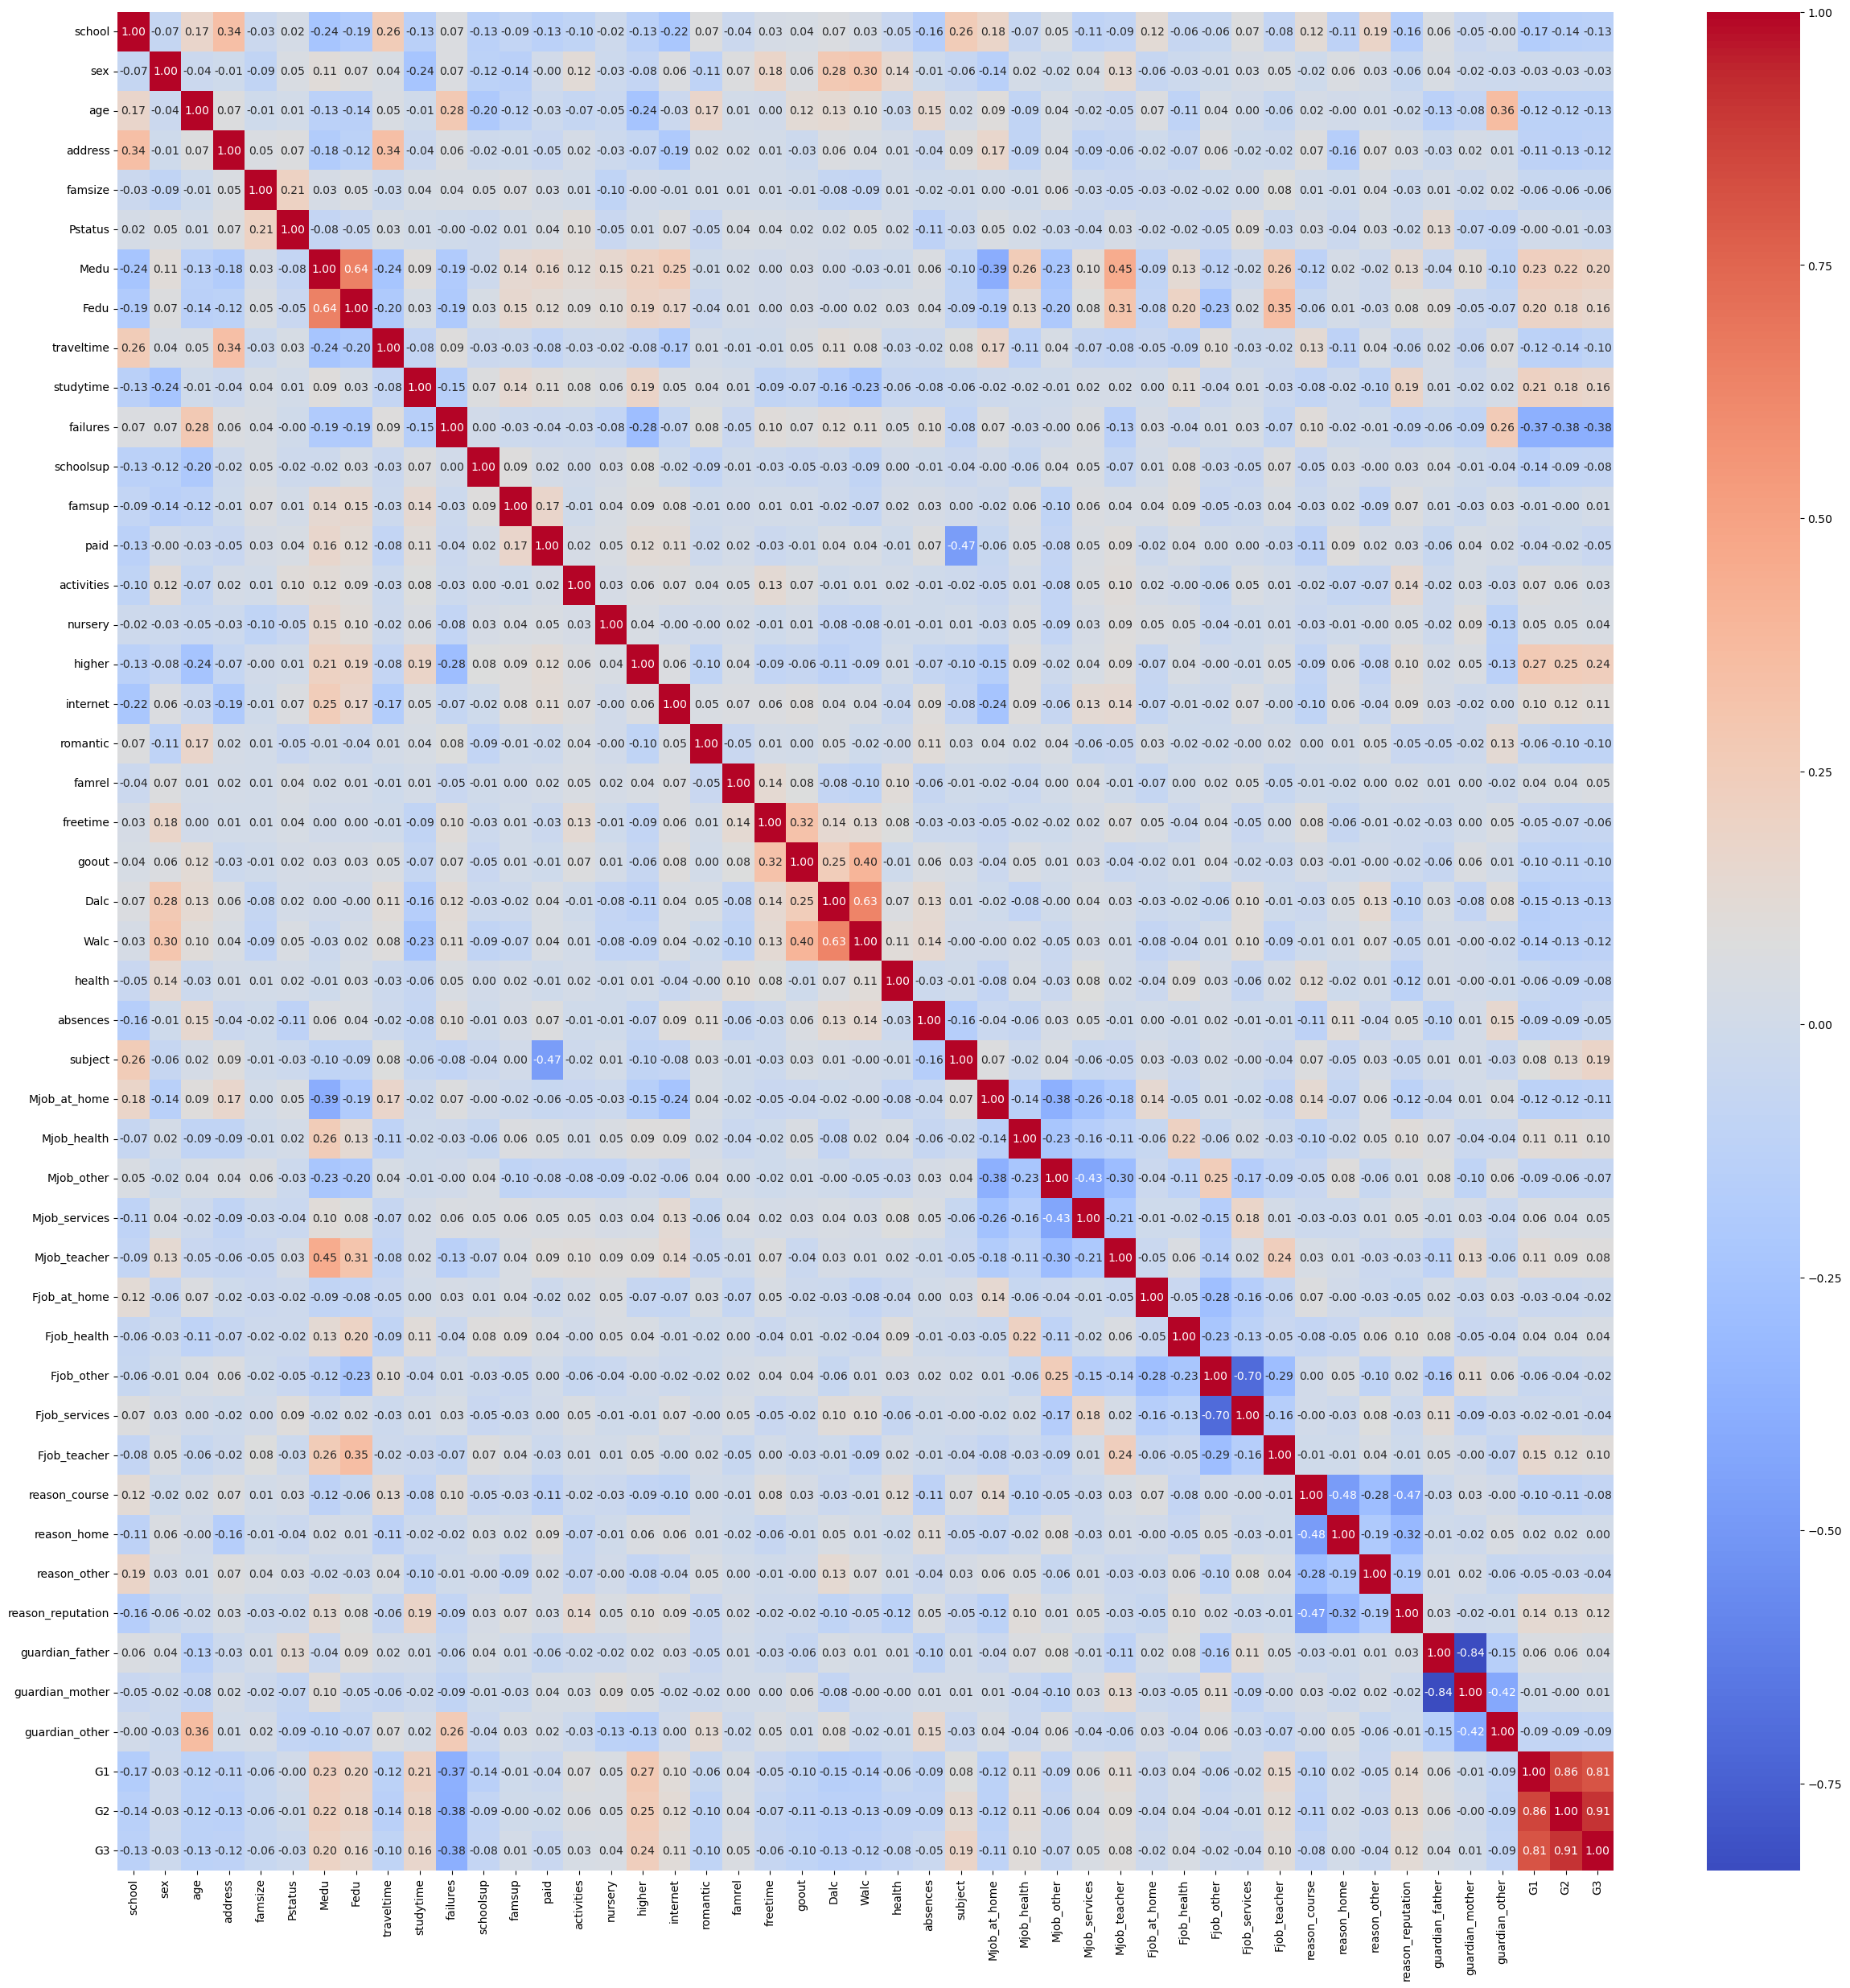

In [8]:
# calculate the correlation matrix on the numeric columns
corr = merged_num.corr()

# plot the heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")

##### Observations

1. Students attending the “GP” school generally exhibit slightly lower performance across all subjects. Additionally, this school shows a slight negative correlation with both paid supplementary educational support and, unfortunately, school-provided support.

2. There are negligible differences in performance between male and female students.
3. Students enrolled in “MS” tend to reside in more rural areas. Consequently, these students typically experience longer travel times and have less access to the internet.
4. Older students are more likely to attend “MS.”
5. Lower parental education levels are associated with a greater likelihood of attending the “GP” school.
6. There is a strong negative correlation between the variables “paid” and “subject,” indicating that students predominantly receive tutoring for mathematics.
7. Interestingly, older students tend to have slightly lower performance. However, this correlation may be misleading, as age is also positively associated with having a guardian other than one’s parents. These students exhibit higher failure rates, and the correlation between guardian status and performance is similar to that of age. Notably, despite their higher failure rates, these students do not perform significantly worse, which appears contradictory to the typical relationship between failures and performance.
8. As expected, the more times a student has failed in the past, the poorer their current performance tends to be.
9. Predictably, higher parental education levels are associated with better student performance, fewer failures, and shorter travel times. The latter may be explained by the fact that more highly educated occupations tend to offer higher incomes, enabling families to choose residences with better infrastructure, such as proximity to schools. Students from these households also tend to aspire to higher education, participate in paid additional classes (potentially to enhance already strong performance rather than compensate for deficiencies), and have greater internet access. This is further supported by the slight positive relationship between parental education levels and family educational support (“famsup”). However, there is negligible correlation between parental education and student study time, suggesting that study time alone may not necessarily influence grades.
10. Aspiring to higher education also shows a slight positive correlation with better grades. In relation to point 9, this suggests some degree of multicollinearity in these factors.
11. More frequent social outings and higher alcohol consumption are both slightly negatively correlated with academic performance. Alcohol consumption also correlates with reduced study time.
12. Parental occupations are positively correlated with each other, suggesting that parents may have met through their work. Similarly, their education levels are highly positively correlated.
13. Contrary to intuition, there is minimal correlation between free time and study time. Regardless of the amount of free time a student has, this does not appear to influence study time. In turn, study time itself is only slightly positively correlated with performance
14. Additionally, performance in Portuguese appears to be one of the few attributes that improve over time, whereas students with parents who are teachers tend to see a decline in performance. Moreover, the correlation between study time and performance decreases over the school year. This may be due to increased subject mastery reducing the need to study, or to fatigue leading students to study less as the year progresses.
15. Interestingly, there is no observable correlation between parental cohabitation status (Pstatus) and student grades. However, there is a slight negative relationship between academic performance and the student’s romantic status, indicating that students in romantic relationships tend to perform worse.

#### Distribution

array([[<Axes: title={'center': 'school'}>,
        <Axes: title={'center': 'sex'}>, <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'address'}>,
        <Axes: title={'center': 'famsize'}>,
        <Axes: title={'center': 'Pstatus'}>,
        <Axes: title={'center': 'Medu'}>],
       [<Axes: title={'center': 'Fedu'}>,
        <Axes: title={'center': 'traveltime'}>,
        <Axes: title={'center': 'studytime'}>,
        <Axes: title={'center': 'failures'}>,
        <Axes: title={'center': 'schoolsup'}>,
        <Axes: title={'center': 'famsup'}>,
        <Axes: title={'center': 'paid'}>],
       [<Axes: title={'center': 'activities'}>,
        <Axes: title={'center': 'nursery'}>,
        <Axes: title={'center': 'higher'}>,
        <Axes: title={'center': 'internet'}>,
        <Axes: title={'center': 'romantic'}>,
        <Axes: title={'center': 'famrel'}>,
        <Axes: title={'center': 'freetime'}>],
       [<Axes: title={'center': 'goout'}>,
        <Axes: title={'c

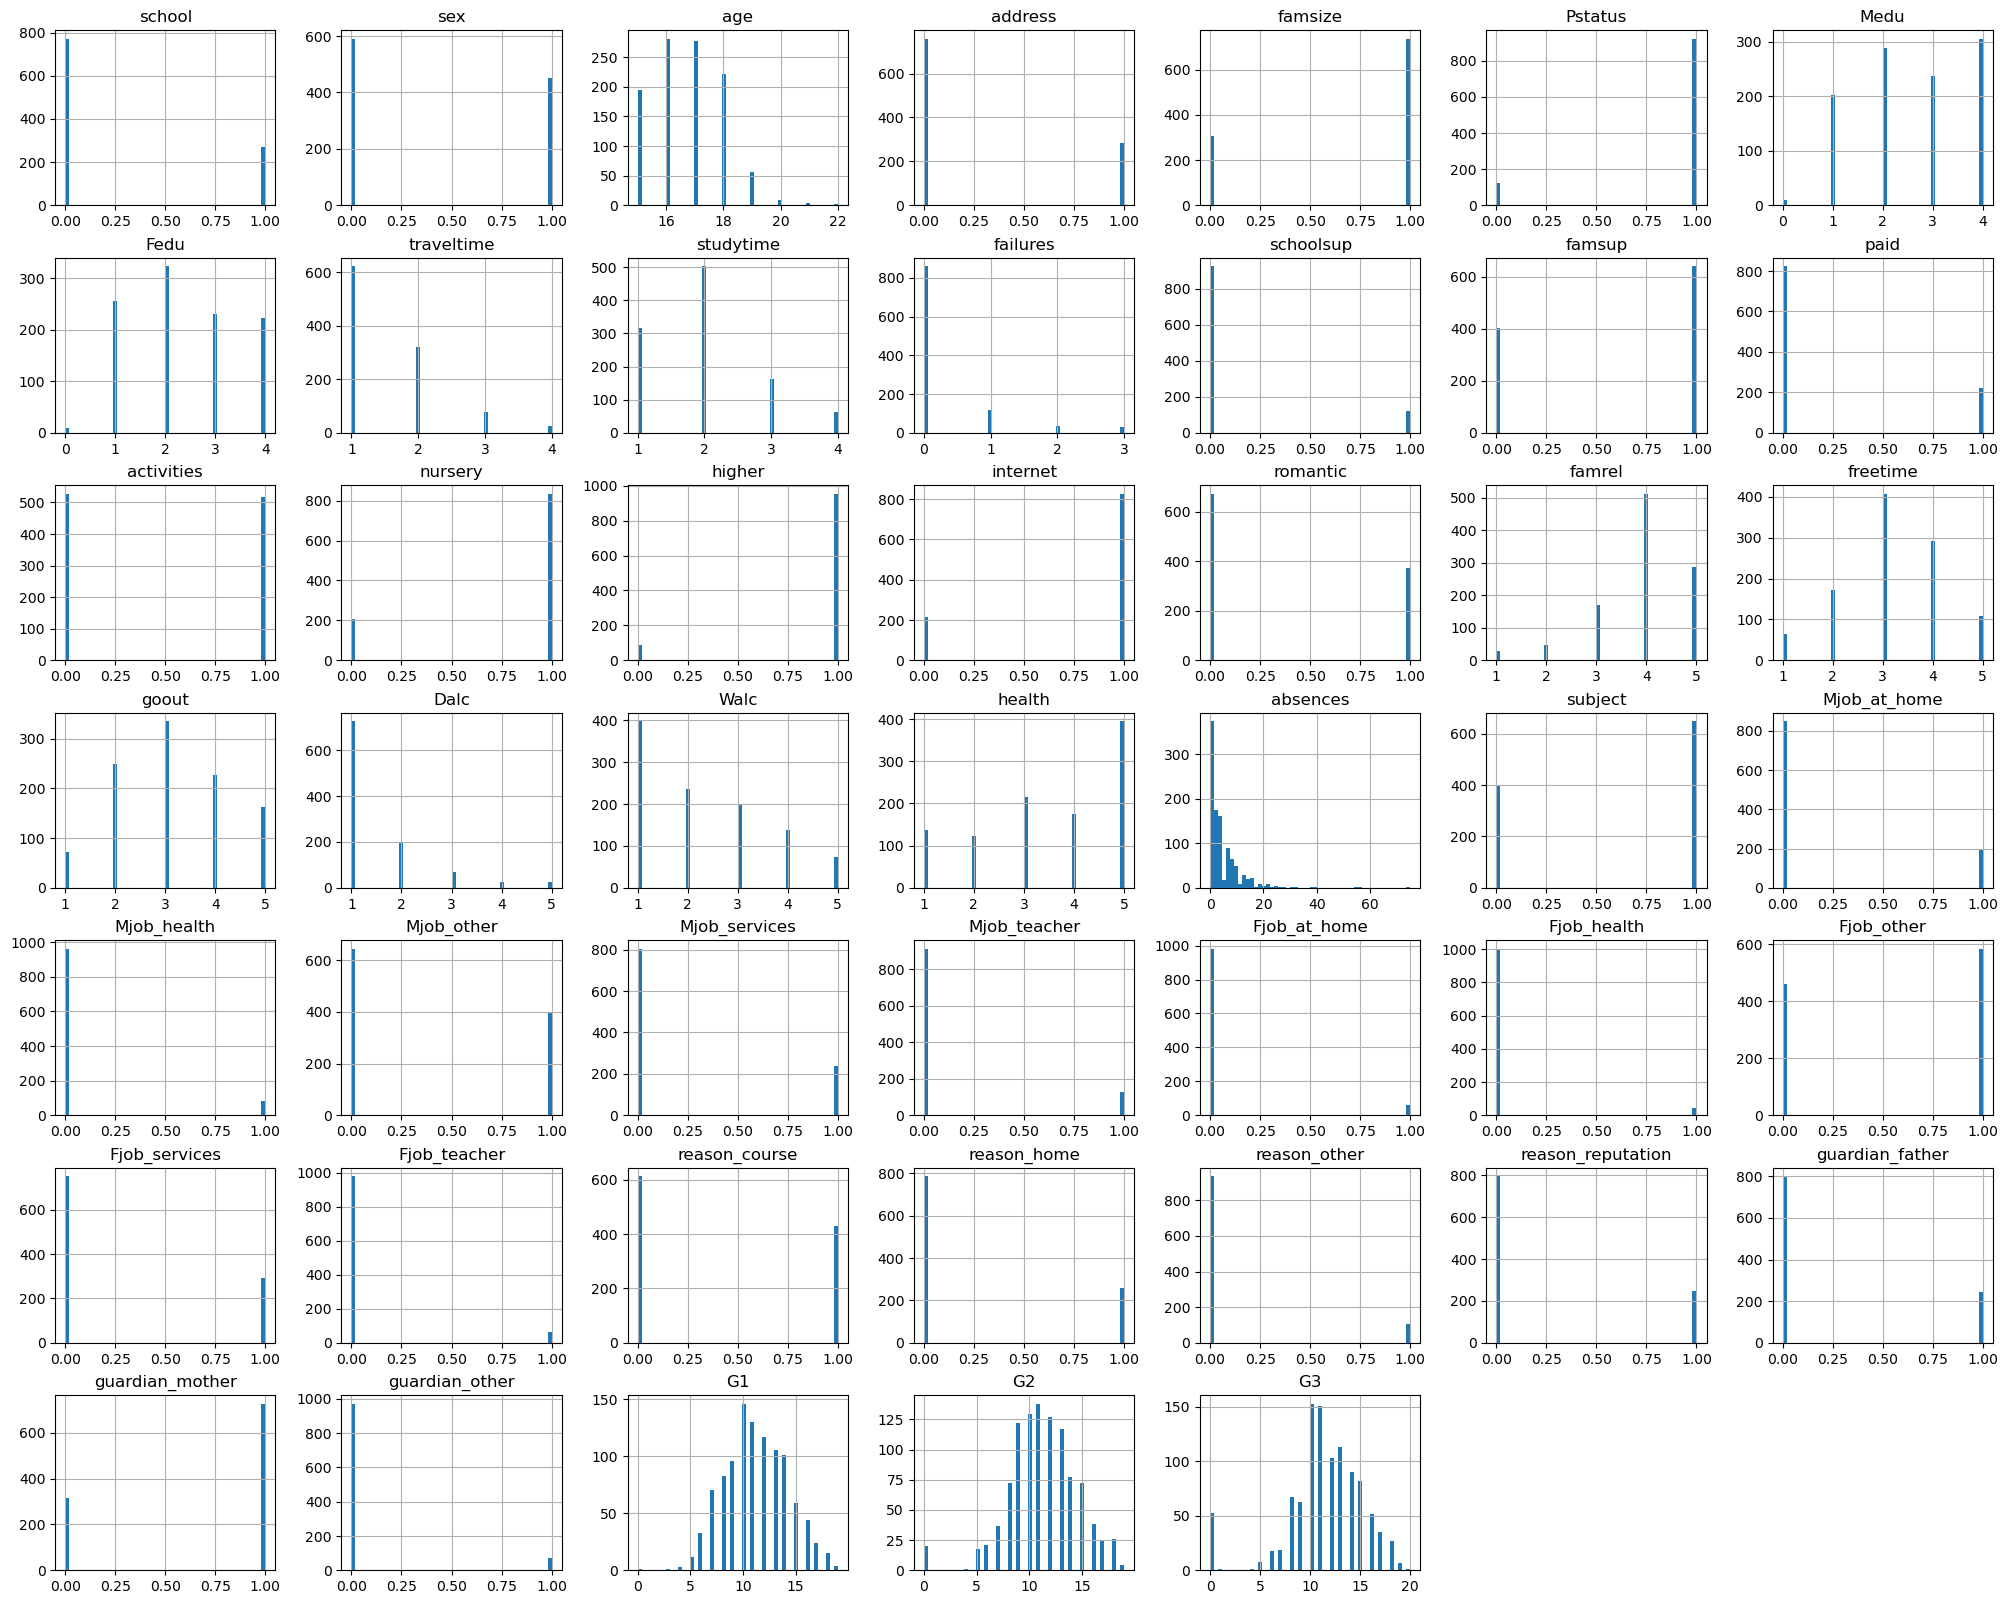

In [9]:
merged_num.hist(bins=50, figsize=(25, 20))

In [10]:
# Create a DataFrame with mean and std for G1, G2, G3
stats_table = pd.DataFrame({
    "Mean": [
        merged_num["G1"].mean(),
        merged_num["G2"].mean(),
        merged_num["G3"].mean()
    ],
    "Standard Deviation": [
        merged_num["G1"].std(),
        merged_num["G2"].std(),
        merged_num["G3"].std()
    ]
}, index=["G1", "G2", "G3"])

# Display the table
print(stats_table)

         Mean  Standard Deviation
G1  11.213602            2.983394
G2  11.246169            3.285071
G3  11.341954            3.864796


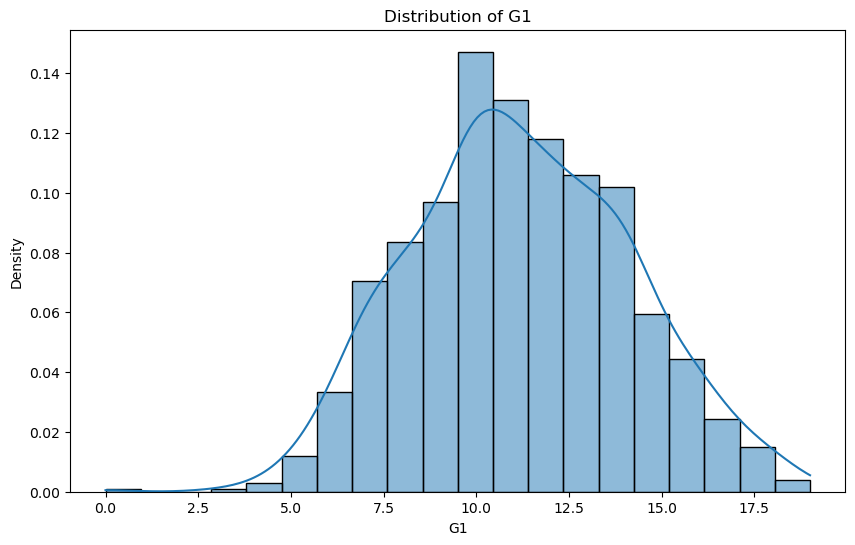

In [11]:
# histogram of g1 with y scale being relative frequency
plt.figure(figsize=(10, 6))
sns.histplot(merged_num["G1"], bins=20, kde=True, stat="density")
plt.title("Distribution of G1")
plt.xlabel("G1")
plt.ylabel("Density")
plt.show()

##### Observations

1. The distributions of G1 to G3 approximate a normal distribution, with grade 10 as the modal value. However, variability increases over time: G1 exhibits a relatively smooth distribution (standard deviation = 2.98), while G3 shows a sharper decline for grades below 10. Grades above 10 remain approximately normally distributed but with greater steepness than in G1 (standard deviation = 3.8). Additionally, the frequency of zero grades increases in later periods.

2. The majority of students are aged between 15 and 18 years.

3. Fathers tend to have higher educational attainment compared to mothers.

4. Most students report studying between 2 and 5 hours or less.

5. A substantial majority of students reside within 30 minutes of the school.

6. Most students describe having a normal or high amount of free time. It is important to note that this is a subjective scale, as perceptions of “low” free time may vary among respondents.

7. The distribution of students' reported frequency of going out approximates a normal distribution. Again, this is based on a subjective scale, where interpretations of “low” frequency may differ between individuals.

8. Daily and weekly alcohol consumption are measured on comparable scales. Students generally report lower daily consumption relative to weekly consumption, suggesting that drinking may increase during social outings.

9. Students’ self-reported health perceptions appear inversely related to weekly alcohol consumption. However, given the small correlation observed in the correlation matrix, this apparent inverse relationship may be spurious.

10. Most students maintain a high attendance rate.

11. Mothers are more often stay-at-home caregivers compared to fathers. Nevertheless, both parents are employed in most cases, most commonly in the “other” occupational category.

12. The most frequently cited reason for school choice is the available course offerings. Reputation and proximity to home are equally likely to be motivating factors.

13. The mother is most often identified as the primary guardian.

14. There is some class imbalance in the distribution of schools attended and in sex. School “GP” is represented approximately 2.5 times more often than “MS.” Additionally, there is a slight overrepresentation of female students in the dataset.

15. Nearly one-third of students report being in a romantic relationship.

16. The vast majority of students have internet access and express intentions to pursue higher education and/or nursery training.

17. Certain grades are missing (e.g., 1–4) or substantially underrepresented (e.g., 14–20).


### Takeaways

1. The distribution of grades approximately follows a normal curve, resulting in class imbalance. Grades situated near the center of the scale are substantially more prevalent than those at the extremes. This imbalance must be considered during model evaluation to ensure fair performance assessment.

2. A notable emergence of zero grades occurs after the first academic period. This anomaly warrants further investigation, as it may reflect external factors such as student dropout or school transfer. Such instances introduce noise into the dataset. As a result, potential explanations will be explored, and data points will be removed where deemed appropriate within a designated preprocessing pipeline. However, it is important to emphasize that, in practical applications, data removal should only follow verification by relevant school authorities to determine whether these zero grades are legitimate academic outcomes or the result of external circumstances. If they represent genuine results, such data should be retained. The methodology for handling these cases will be clearly stated in subsequent sections of the notebook.

3. The dataset exhibits both multicollinearity and non-linear relationships among predictive variables. Examples include correlations among parental education, aspirations for higher education, and academic performance, as well as complex interactions between age, failure history, and legal guardianship.

4. The dataset contains a relatively high number of variables compared to the number of observations. As a result, dimensionality reduction is likely necessary to improve model performance and reduce overfitting.


### Inspection of zero grades

In [12]:
zero_performance = merged_num[(merged_num["G1"] == 0) | (merged_num["G2"] == 0) | (merged_num["G3"] == 0)]
zero_performance

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,G1,G2,G3
128,0,1,18,1,1,1,2,2,1,1,...,0,0,0,1,0,1,0,7,4,0
130,0,0,15,1,1,1,3,4,2,3,...,1,0,0,0,1,0,0,12,0,0
131,0,0,15,0,1,1,1,1,3,1,...,1,0,0,0,0,1,0,8,0,0
134,0,1,15,1,1,1,3,4,4,2,...,1,0,0,0,0,1,0,9,0,0
135,0,0,15,0,1,1,4,4,1,3,...,1,0,0,0,0,1,0,11,0,0
136,0,1,17,1,1,1,3,4,3,2,...,1,0,0,0,0,1,0,10,0,0
137,0,0,16,0,1,0,3,3,2,1,...,1,0,0,0,0,0,1,4,0,0
140,0,1,15,0,1,1,4,3,2,4,...,1,0,0,0,1,0,0,7,9,0
144,0,1,17,0,1,1,2,1,1,1,...,0,1,0,0,0,1,0,5,0,0
146,0,0,15,0,1,1,3,2,1,2,...,0,1,0,0,1,0,0,6,7,0


array([[<Axes: title={'center': 'school'}>,
        <Axes: title={'center': 'sex'}>, <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'address'}>,
        <Axes: title={'center': 'famsize'}>,
        <Axes: title={'center': 'Pstatus'}>,
        <Axes: title={'center': 'Medu'}>],
       [<Axes: title={'center': 'Fedu'}>,
        <Axes: title={'center': 'traveltime'}>,
        <Axes: title={'center': 'studytime'}>,
        <Axes: title={'center': 'failures'}>,
        <Axes: title={'center': 'schoolsup'}>,
        <Axes: title={'center': 'famsup'}>,
        <Axes: title={'center': 'paid'}>],
       [<Axes: title={'center': 'activities'}>,
        <Axes: title={'center': 'nursery'}>,
        <Axes: title={'center': 'higher'}>,
        <Axes: title={'center': 'internet'}>,
        <Axes: title={'center': 'romantic'}>,
        <Axes: title={'center': 'famrel'}>,
        <Axes: title={'center': 'freetime'}>],
       [<Axes: title={'center': 'goout'}>,
        <Axes: title={'c

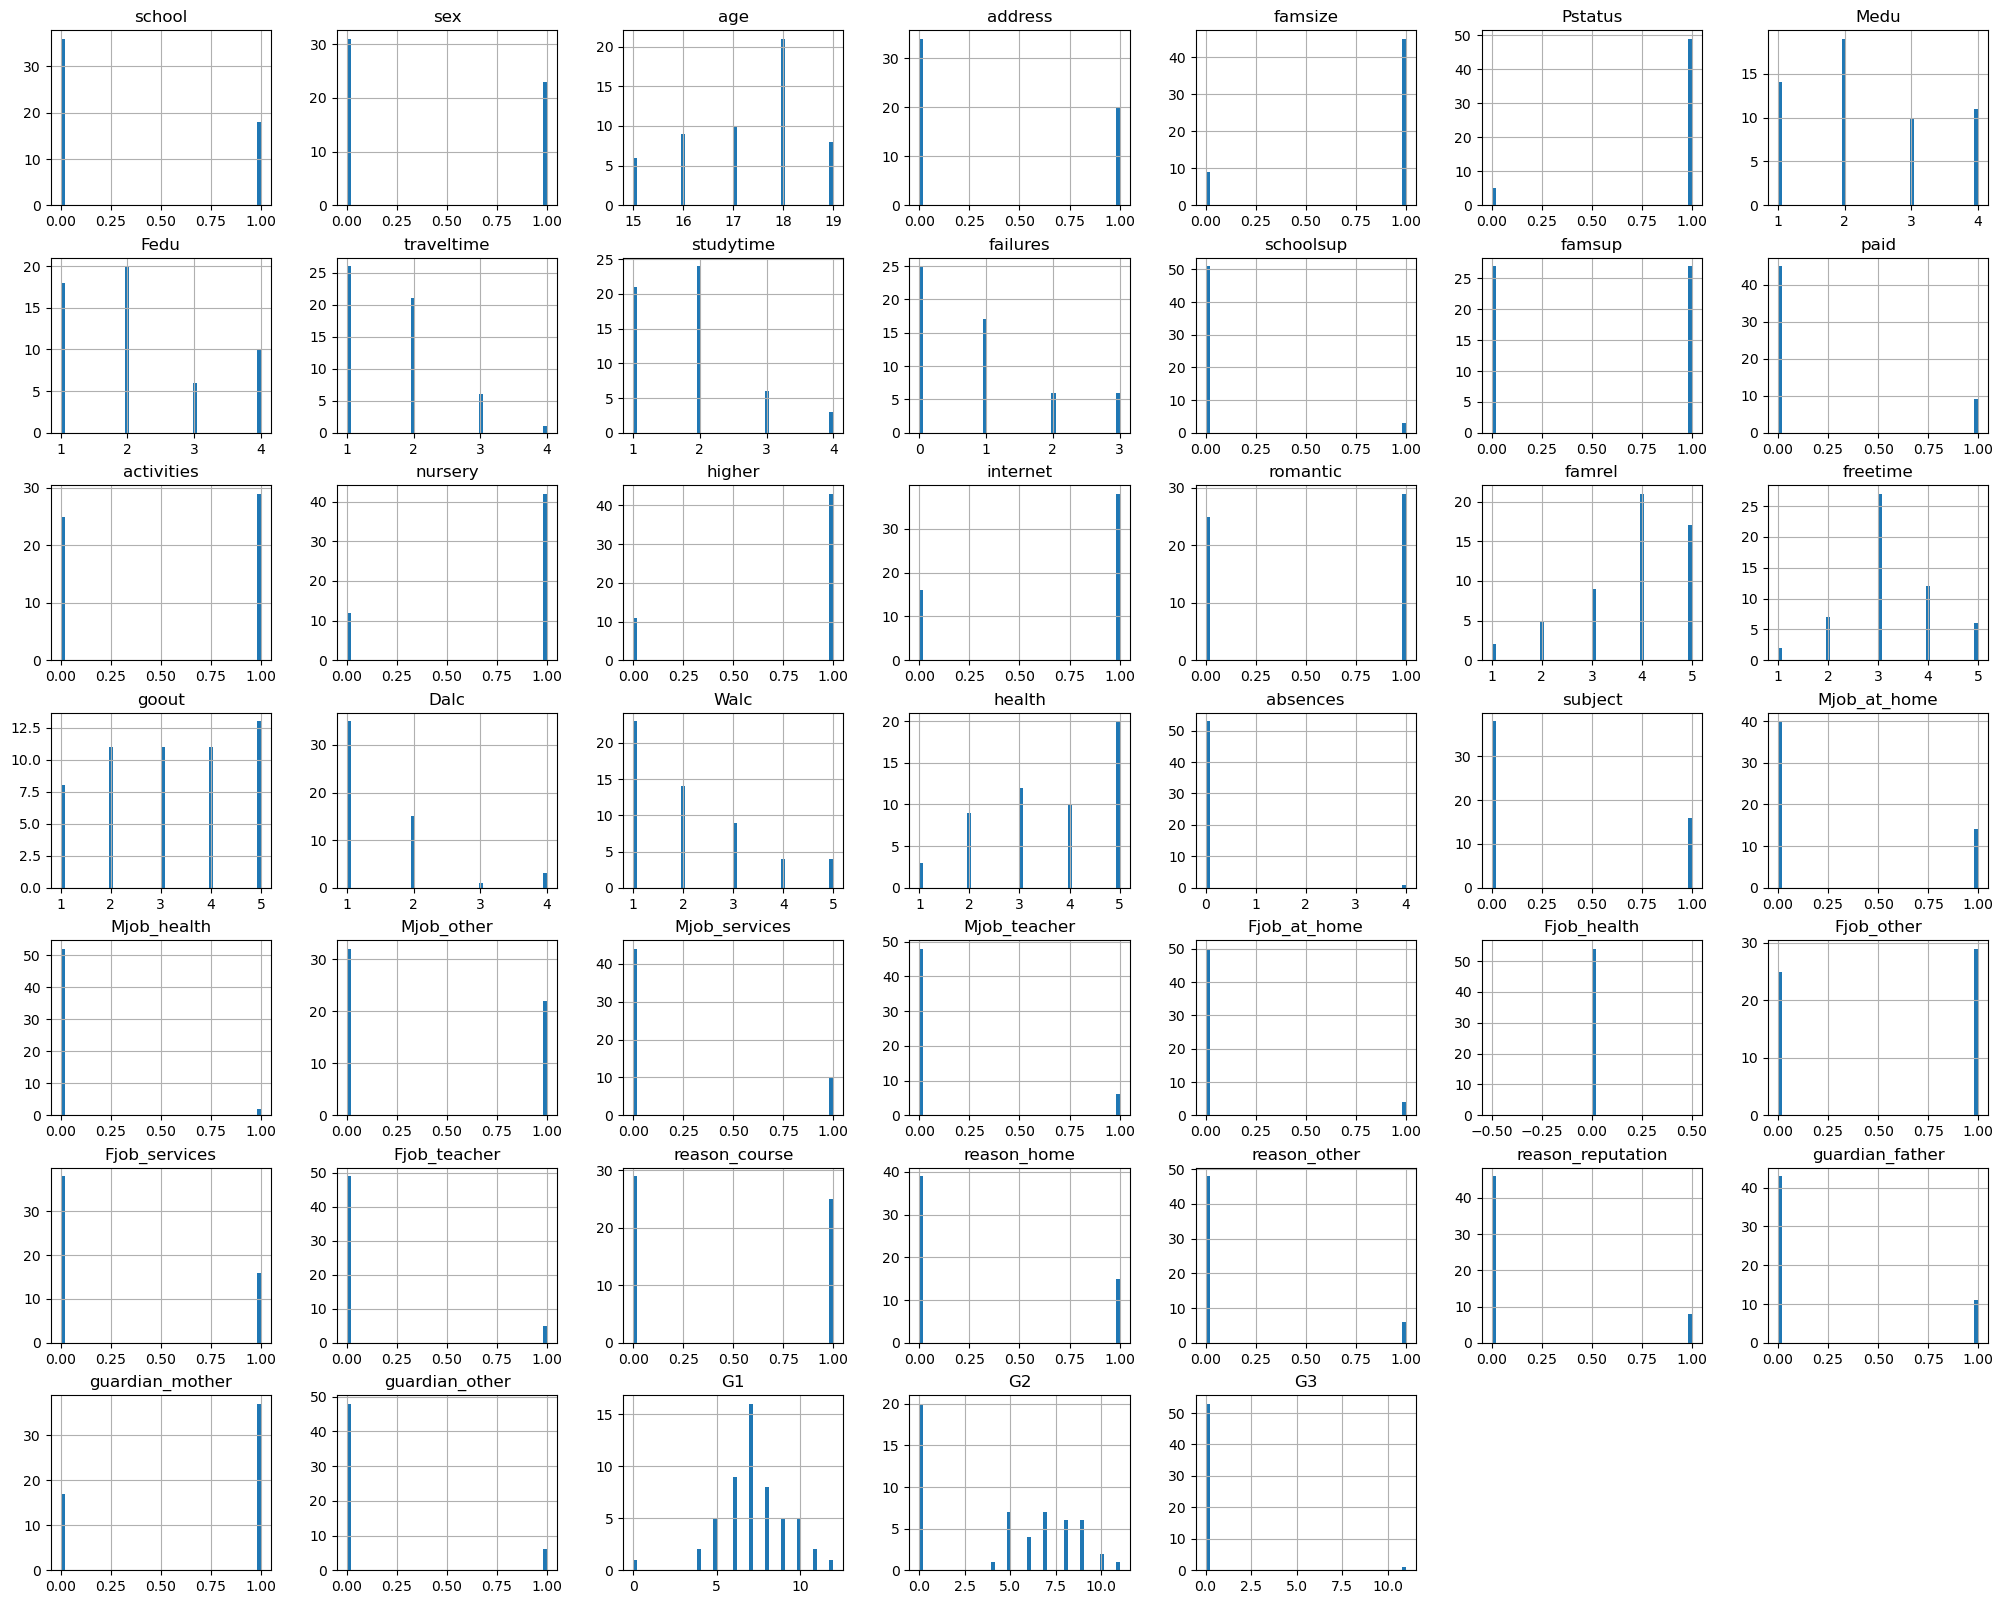

In [13]:
zero_performance.hist(bins=50, figsize=(25, 20))

#### Observation

Many factors appear acceptable or typical, such as low levels of alcohol consumption, minimal absences, and distributions that align with the trends observed in earlier analyses. Nonetheless, several aspects raise concerns:

1. The grades in G1 and G2 are both below average. Drawing on Cortez and Silva (2008), scores below 10 in G3 are considered failing. Applying this threshold to G1 suggests that only a small proportion of students would have passed.

2. Failure rates are above average.

3. Study time is relatively low, although this is consistent with the overall dataset, as seen in the previous histogram.

4. Parental education levels are both below the dataset average.

5. Despite fewer observations for mathematics, failures appear disproportionately concentrated in that subject.

6. Students report going out more frequently than average.

7. A substantial proportion of students are in romantic relationships.

8. Grades show marked deterioration over the school year.

Given the absence of recorded absences, it is reasonable to assume these students remained enrolled throughout the year. However, no consistent set of explanatory rules emerges from the data; only a series of irregular values are evident. As such, the underlying causes of failure cannot be directly inferred and must instead be learned by predictive models.

The only discernible pattern is that students appear to "give up" over time, performing poorly in G1 (and/or G2) and subsequently failing to an even greater extent in later periods. This suggests a need for timely intervention by schools, which does not appear to be happening, as indicated by the distribution of the "schoolsup" variable.

Returning to the motivation for this project, we argue that predicting G1 is of primary importance, as it is highly correlated with subsequent academic performance (as shown in the correlation matrix). Identifying students likely to perform poorly early in the year would enable schools to provide targeted, preemptive support, aiming to reduce the risk of students disengaging over time.


### Inspecting performance over the school year

In [14]:
# Here we only look at non-zero values so we can analyse the usual behavior
good_performance = merged_num[(merged_num["G1"] != 0) & (merged_num["G2"] != 0) & (merged_num["G3"] != 0)]

In [15]:
# Calculate the differences
merged_num['G1_G2_diff'] = merged_num['G1'] - merged_num['G2']
merged_num['G1_G3_diff'] = merged_num['G1'] - merged_num['G3']

# Create a DataFrame with mean and standard deviation for the differences
diff_stats_table = pd.DataFrame({
    "Mean": [
        merged_num['G1_G2_diff'].mean(),
        merged_num['G1_G3_diff'].mean()
    ],
    "Standard Deviation": [
        merged_num['G1_G2_diff'].std(),
        merged_num['G1_G3_diff'].std()
    ]
}, index=["G1-G2 Difference", "G1-G3 Difference"])

# Display the table
print(diff_stats_table)

                      Mean  Standard Deviation
G1-G2 Difference -0.032567            1.691129
G1-G3 Difference -0.128352            2.275553


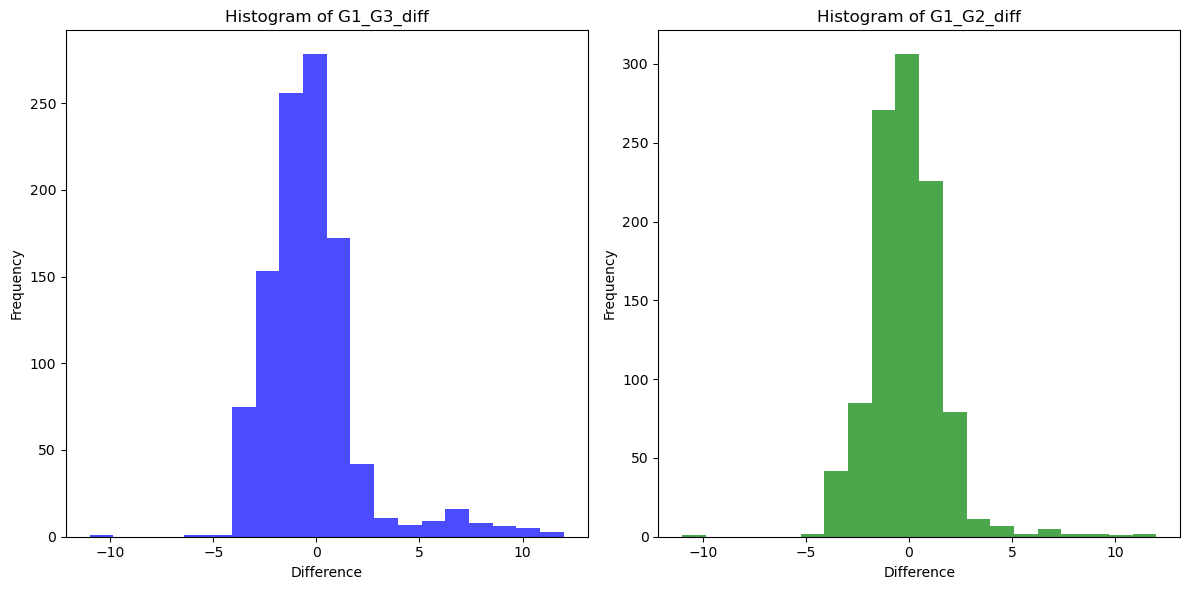

In [16]:
plt.figure(figsize=(12, 6))

# Histogram for G1_G3_diff
plt.subplot(1, 2, 1)
plt.hist(merged_num['G1_G3_diff'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of G1_G3_diff')
plt.xlabel('Difference')
plt.ylabel('Frequency')

# Histogram for G1_G2_diff
plt.subplot(1, 2, 2)
plt.hist(merged_num['G1_G2_diff'], bins=20, color='green', alpha=0.7)
plt.title('Histogram of G1_G2_diff')
plt.xlabel('Difference')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [17]:
# Create a DataFrame with mean and std for G1, G2, G3
good_perm_stats_table = pd.DataFrame({
    "Mean": [
        good_performance["G1"].mean(),
        good_performance["G2"].mean(),
        good_performance["G3"].mean()
    ],
    "Standard Deviation": [
        good_performance["G1"].std(),
        good_performance["G2"].std(),
        good_performance["G3"].std()
    ]
}, index=["G1", "G2", "G3"])

# Display the table
print(good_perm_stats_table)

         Mean  Standard Deviation
G1  11.429293            2.874270
G2  11.612121            2.832545
G3  11.949495            2.913563


#### Observations
As we can see the performance on average stays the same, with slight positiv and negativ increases. In the vast majority of the time, student's grades don't change more than a value of 5. However, there are a few outliers whose performance greatly increases from G1 to G3. Moreover, on average the grades get better in G3 but they deviate even more. And even after ignoring 0-scores, the average performance of the students remains sub-optimal, i.e. under 12. This corresponds to a C or "satisfactory" (Cortez and Silvia, 2008, p.4). So the G1 score can more or less be seen as the predicted end of year result.

## Pre-processing

### Basic train-test-split

In [18]:
X = merged_num.drop(columns=["G1", "G2", "G3", "G1_G3_diff", "G1_G2_diff"])
y = merged_num[["G1"]]
random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

scaling so that distance based models wont have sub-optimal data

In [19]:
# Fit on training data or else we have data leakage
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [20]:
X_test_scaled = scaler.transform(X_test)

### PCA

To limit the amount of features that the models need to take into account

In [21]:
# Fit on training data or else we have data leakage
pca = PCA()
pca.fit(X_train_scaled)

PCA()

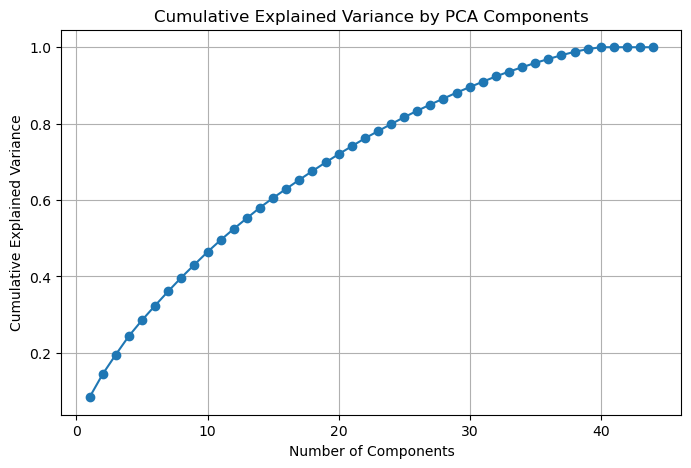

In [22]:
# Compute cumulative sum
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

We will train data on PCA with 20 and 30 components as the amount of dimensions and their respective explained variance seems reasonable

In [23]:
pca_20 = PCA(n_components=20)
X_train_scaled_20 = pca_20.fit_transform(X_train_scaled)
X_test_scaled_20 = pca_20.transform(X_test_scaled)

pca_30 = PCA(n_components=30)
X_train_scaled_30 = pca_30.fit_transform(X_train_scaled)
X_test_scaled_30 = pca_30.transform(X_test_scaled)



## Basic machine learning model initializations

### Training the basic models

Lets train some models, these range in complexity and underlying algorithm (i.e. distance, tree-based or ensemble): Linear Regression, K-NN, Radius Nearest Neighbor, Decision Tree, Random Forest, XGBoost, NN, Voting and Stacking ensemble models, Bayesian LR, and Gradient Boosting Regressor

In [24]:
# Code structure inspired by sample submission
models = {
    "Baselinbe: Linear Regression (LR)": LinearRegression(),
    "K-NN": KNeighborsRegressor(),
    "Radius-NN (RNN)": RadiusNeighborsRegressor(radius=0.1),
    "Decision Tree Regressor (DT or DTR)": DecisionTreeRegressor(),
    "Random Forest (RF or RFR)": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "Neural Net (NN)": MLPRegressor(), # Add regularization
    "Bayesian Ridge Regression (NB or BRR)": BayesianRidge(),
    "Gradient Boosting Regressor (GBR)": GradientBoostingRegressor(),
    "Support Vector Regression (SVR)": SVR()
}

Voting_ensemble = {
    "Voting Ensemble": VotingRegressor(estimators=[(name, model) for name, model in models.items()])
}

# Stacking Ensemble
Stacking_ensemble = {
    "Stacking Ensemble": StackingRegressor(estimators=[(name, model) for name, model in models.items()], final_estimator=XGBRegressor())
}

Stacking_ensembl_cv = {
    "Stacking Ensemble with CV": StackingRegressor(estimators=[(name, model) for name, model in models.items()], cv=5 ,final_estimator=XGBRegressor())
}

# Combine all models into a single dictionary
all_models = {**models, **Voting_ensemble, **Stacking_ensemble, **Stacking_ensembl_cv}

# Function to evaluate models with training and test results
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    predictions = {}
    
    for name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train.values.ravel())
        
        # Make predictions
        y_pred_train = model.predict(X_train).round(0)
        y_pred_test = model.predict(X_test).round(0)
        predictions[name] = {
            "train": y_pred_train,
            "test": y_pred_test
        }
        # Calculate metrics
        rmse_train = root_mean_squared_error(y_train, y_pred_train)
        rmse_test = root_mean_squared_error(y_test, y_pred_test)
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        # Store results
        results[name] = {
            "RMSE Train": rmse_train,
            "MAE Train": mae_train,
            "R2 Train": r2_train,
            "MAE Test": mae_test,
            "RMSE Test": rmse_test,
            "R2 Test": r2_test
        }
    # Convert results to DataFrame
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values(by="RMSE Test")
    return results_df, predictions


# Evaluate models on the original data
results_original, predictions_original = evaluate_models(all_models, X_train, y_train, X_test, y_test)

# Evaluate models on the scaled data
results_scaled, predictions_scaled = evaluate_models(all_models, X_train_scaled, y_train, X_test_scaled, y_test)

# Evaluate models on the PCA transformed data
results_pca_20, predictions_pca_20 = evaluate_models(all_models, X_train_scaled_20, y_train, X_test_scaled_20, y_test)
results_pca_30, predictions_pca_30 = evaluate_models(all_models, X_train_scaled_30, y_train, X_test_scaled_30, y_test)



/opt/anaconda3/envs/education/lib/python3.13/site-packages/numpy/_core/numeric.py:476: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
/opt/anaconda3/envs/education/lib/python3.13/site-packages/numpy/_core/numeric.py:476: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
/opt/anaconda3/envs/education/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/education/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/education/lib/python3.13/site-packages/numpy/_core/numeric.py:476: RuntimeWarning: invalid value enc

In [25]:
# Calculate the RMSE of a naive model that predicts the mean of G1
naive_rmse = root_mean_squared_error(y_test, np.full_like(y_test, y_train.mean()))
print(f"Naive RMSE: {naive_rmse:.2f}")

Naive RMSE: 2.99


In [26]:
results_original.sort_values(by="RMSE Test", ascending=True).round(2)

,RMSE Train,MAE Train,R2 Train,MAE Test,RMSE Test,R2 Test
Random Forest (RF or RFR),0.98,0.73,0.89,1.90,2.52,0.28
Gradient Boosting Regressor (GBR),1.89,1.48,0.60,1.96,2.56,0.26
XGBoost,0.04,0.00,1.00,1.96,2.63,0.22
Bayesian Ridge Regression (NB or BRR),2.45,1.92,0.33,2.05,2.68,0.19
Baselinbe: Linear Regression (LR),2.44,1.93,0.33,2.09,2.70,0.17
Neural Net (NN),2.26,1.76,0.43,2.14,2.76,0.14
Voting Ensemble,1.45,1.12,0.76,2.11,2.77,0.13
Stacking Ensemble,1.84,1.33,0.62,2.12,2.81,0.11
Support Vector Regression (SVR),2.70,2.13,0.18,2.19,2.82,0.10
Stacking Ensemble with CV,1.80,1.35,0.64,2.22,2.92,0.04


#### Intermediate Observations

1. The RNN, Decision Tree Regressor (DTR), and XGBoost models achieve near-perfect performance on the training data. However, their substantial decline in performance on the test data indicates significant overfitting. In particular, the RNN requires comprehensive hyperparameter tuning to enable a fair assessment of its predictive capabilities.

2. The Random Forest model demonstrates strong performance on the training set and achieves the best results on the test data among the models evaluated. Nevertheless, its overall performance remains limited, with an $R^2$ value of 0.29 and a root mean squared error (RMSE) that is only approximately 10% lower than the baseline established by the Linear Regression model.

3. Notably, XGBoost and the Gradient Boosting Regressor exhibit very similar test set results despite XGBoost displaying severe overfitting on the training data.


In [27]:
results_scaled.sort_values(by="RMSE Test", ascending=True).round(2)

,RMSE Train,MAE Train,R2 Train,MAE Test,RMSE Test,R2 Test
Random Forest (RF or RFR),0.98,0.71,0.89,1.90,2.49,0.30
Gradient Boosting Regressor (GBR),1.89,1.48,0.60,1.96,2.56,0.26
Support Vector Regression (SVR),2.09,1.49,0.51,1.98,2.58,0.25
Neural Net (NN),1.66,1.28,0.69,2.07,2.62,0.22
XGBoost,0.04,0.00,1.00,1.96,2.63,0.22
Bayesian Ridge Regression (NB or BRR),2.47,1.95,0.32,2.06,2.69,0.19
Stacking Ensemble,1.86,1.36,0.61,2.07,2.70,0.18
Baselinbe: Linear Regression (LR),2.44,1.93,0.33,2.09,2.70,0.17
Stacking Ensemble with CV,1.89,1.41,0.60,2.05,2.71,0.17
Voting Ensemble,1.31,0.98,0.81,2.09,2.74,0.15


#### Intermediate Observations
1. The RNN, Decision Tree Regressor (DTR), and XGBoost models once again exhibit clear signs of overfitting.

2. The Support Vector Regressor (SVR) showed substantial improvement with scaled data, reducing RMSE by 23% on the training set and 9% on the test set.

3. The Neural Network also achieved improved performance on the training data; however, its test performance increased only marginally.

4. Most models were minimally affected by the scaling process. Notably, the K-Nearest Neighbors (KNN) model demonstrated only a slight performance gain, likely because many input variables were already on comparable scales (e.g., 1–5 ratings), reducing the overall impact of scaling.


In [28]:
results_pca_20.sort_values(by="RMSE Test", ascending=True).round(2)

,RMSE Train,MAE Train,R2 Train,MAE Test,RMSE Test,R2 Test
Random Forest (RF or RFR),1.01,0.74,0.88,1.94,2.60,0.24
Support Vector Regression (SVR),2.23,1.62,0.44,2.01,2.64,0.22
Gradient Boosting Regressor (GBR),1.61,1.28,0.71,2.03,2.64,0.21
Bayesian Ridge Regression (NB or BRR),2.59,2.05,0.25,2.07,2.71,0.17
Baselinbe: Linear Regression (LR),2.57,2.04,0.26,2.10,2.75,0.15
XGBoost,0.00,0.00,1.00,2.13,2.78,0.13
Neural Net (NN),2.18,1.72,0.47,2.15,2.82,0.10
Stacking Ensemble,2.24,1.74,0.44,2.15,2.86,0.08
Voting Ensemble,1.39,1.07,0.78,2.18,2.87,0.07
Stacking Ensemble with CV,2.45,1.78,0.33,2.22,2.89,0.06


#### Intermediate Observations

1. The Random Forest model continues to demonstrate the strongest overall performance.

2. Incorporating PCA negatively affected all models (with the exception of the RNN, which already exhibited extremely poor performance). Notably, while the Gradient Boosting model's training performance improved slightly, its test performance declined.

3. The baseline model’s performance remained consistent.

4. XGBoost and the Neural Network both exhibited greater difficulty modeling the PCA-transformed data, ultimately performing worse than the baseline.

5. Interestingly, the RNN, Decision Tree Regressor (DTR), and Random Forest still displayed severe overfitting despite the reduction of the feature space by approximately 20 dimensions.


In [29]:
results_pca_30.sort_values(by="RMSE Test", ascending=True).round(2)

,RMSE Train,MAE Train,R2 Train,MAE Test,RMSE Test,R2 Test
Random Forest (RF or RFR),1.01,0.74,0.89,2.00,2.61,0.23
Gradient Boosting Regressor (GBR),1.54,1.19,0.74,2.01,2.62,0.22
Support Vector Regression (SVR),2.14,1.54,0.48,2.03,2.62,0.22
Neural Net (NN),1.85,1.46,0.61,2.04,2.63,0.22
XGBoost,0.00,0.00,1.00,2.07,2.63,0.22
Bayesian Ridge Regression (NB or BRR),2.50,1.99,0.30,2.06,2.67,0.20
Baselinbe: Linear Regression (LR),2.48,1.98,0.31,2.10,2.72,0.17
Voting Ensemble,1.33,1.01,0.80,2.19,2.84,0.09
Stacking Ensemble with CV,2.16,1.65,0.48,2.18,2.85,0.08
Stacking Ensemble,2.02,1.49,0.54,2.21,2.86,0.08


#### Intermediate Observations:
1. The performance of XG and NN lost by only using the first 20 components, they regained with the first 30

In [30]:
# Calculate the difference between the original data performance and the rest of the data for each model
def calculate_performance_difference(original_results, new_results):
    difference = {}
    for model in original_results.index:
        if model in new_results.index:
            diff_rmse = original_results.loc[model, "RMSE Test"] - new_results.loc[model, "RMSE Test"]
            diff_mae = original_results.loc[model, "MAE Test"] - new_results.loc[model, "MAE Test"]
            diff_r2 = new_results.loc[model, "R2 Test"] - original_results.loc[model, "R2 Test"]
            difference[model] = {
                "RMSE Difference": diff_rmse,
                "MAE Difference": diff_mae,
                "R2 Difference": diff_r2
            }
    return pd.DataFrame(difference).T
# Calculate performance differences
performance_diff_scaled = calculate_performance_difference(results_original, results_scaled)
performance_diff_pca_20 = calculate_performance_difference(results_original, results_pca_20)
performance_diff_pca_30 = calculate_performance_difference(results_original, results_pca_30)

performance_diff = pd.concat([performance_diff_scaled, performance_diff_pca_20, performance_diff_pca_30], axis=1)
# First 3 columns for scaled data set, next 3 for pca 20 and rest for pca
performance_diff.round(2)

,RMSE Difference,MAE Difference,R2 Difference,RMSE Difference,MAE Difference,R2 Difference,RMSE Difference,MAE Difference,R2 Difference
Random Forest (RF or RFR),0.03,0.00,0.02,-0.08,-0.04,-0.05,-0.09,-0.10,-0.05
Gradient Boosting Regressor (GBR),-0.01,0.00,-0.00,-0.09,-0.06,-0.05,-0.07,-0.04,-0.04
XGBoost,0.00,0.00,0.00,-0.15,-0.16,-0.09,-0.01,-0.10,-0.00
Bayesian Ridge Regression (NB or BRR),-0.01,-0.02,-0.01,-0.04,-0.03,-0.02,0.01,-0.01,0.00
Baselinbe: Linear Regression (LR),0.00,0.00,0.00,-0.04,-0.01,-0.03,-0.01,-0.01,-0.01
Neural Net (NN),0.14,0.08,0.08,-0.06,-0.01,-0.04,0.14,0.10,0.08
Voting Ensemble,0.03,0.03,0.02,-0.10,-0.06,-0.06,-0.07,-0.08,-0.05
Stacking Ensemble,0.11,0.05,0.07,-0.05,-0.03,-0.03,-0.05,-0.09,-0.03
Support Vector Regression (SVR),0.24,0.21,0.15,0.19,0.18,0.12,0.20,0.16,0.12
Stacking Ensemble with CV,0.21,0.17,0.13,0.03,0.00,0.02,0.07,0.04,0.04


Positiv differences are positiv results, i.e. an RMSE difference of 0.5 means we decreased the RMSE of the current inspected model's RMSE by 0.5 in comparison to the comparing dataset.
Negativ differences relate to negative results.

### Overall observations:
1. Despite clear evidence of overfitting, XGBoost achieved performance comparable to other models. Similarly, the Gradient Boosting Regressor demonstrated consistently strong performance across experiments.

2. The Random Forest model maintained stable performance across all data variations and consistently outperformed the other models.

3. Dimensionality reduction led to a decline in performance; however, this reduction was relatively modest, with maximum observed differences of 0.15 in RMSE, 0.16 in MAE, and 0.09 in R².

4. All ensemble models, with the exception of Random Forest, underperformed relative to the baseline model. Notably, incorporating cross-validation further reduced performance, which may be attributable to the limited size of the training data.

5. Even in the best scenario—using scaled data with Random Forest—the improvement over the naive model was limited to an RMSE reduction of approximately 0.5. This suggests a tendency to “overfit” toward predicting the majority class (i.e., the mean), which is a cause for concern.


### Further approach

1. Let us inspect if the data is split equally, i.e. is the distribution of grades maintaned in both sets. (keyword stratisfied sampling)
2. As we showed earlier, some grades are over and underrepresented. We can try over sampling some grades or down-sampling overrepresented grades like 7-14, specifically 10-12 though (see "Distribution of G1" histogram from earlier)

For sake of efficiency and clarity, we will focus only on RF, GBR, XGBoost, BRR, NN, SVR and the LR (our baseline).




## Stratisfied splitting

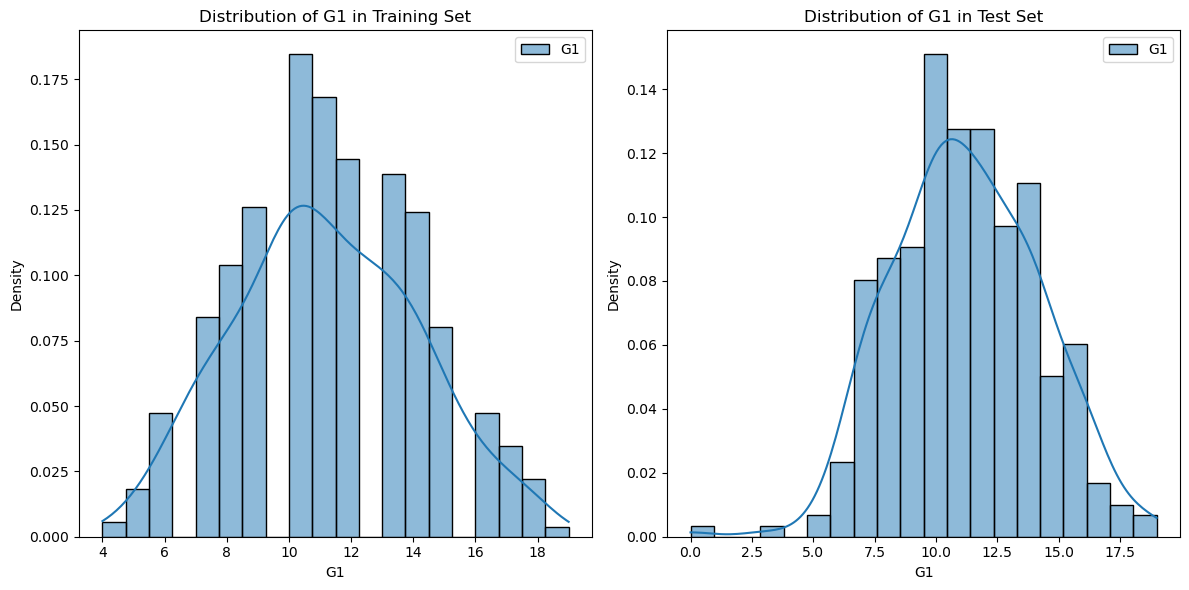

In [31]:
# Histogram chart of G1 in y_train and y_test
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_train, bins=20, kde=True, stat="density")
plt.title("Distribution of G1 in Training Set")
plt.xlabel("G1")
plt.ylabel("Density")
plt.subplot(1, 2, 2)
sns.histplot(y_test, bins=20, kde=True, stat="density")
plt.title("Distribution of G1 in Test Set")
plt.xlabel("G1")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


We can see that the distribution graphs are unequal. This is due to G1 values under 7 and over 13 are not equally represented. Lets fix this and see if this has an impact.

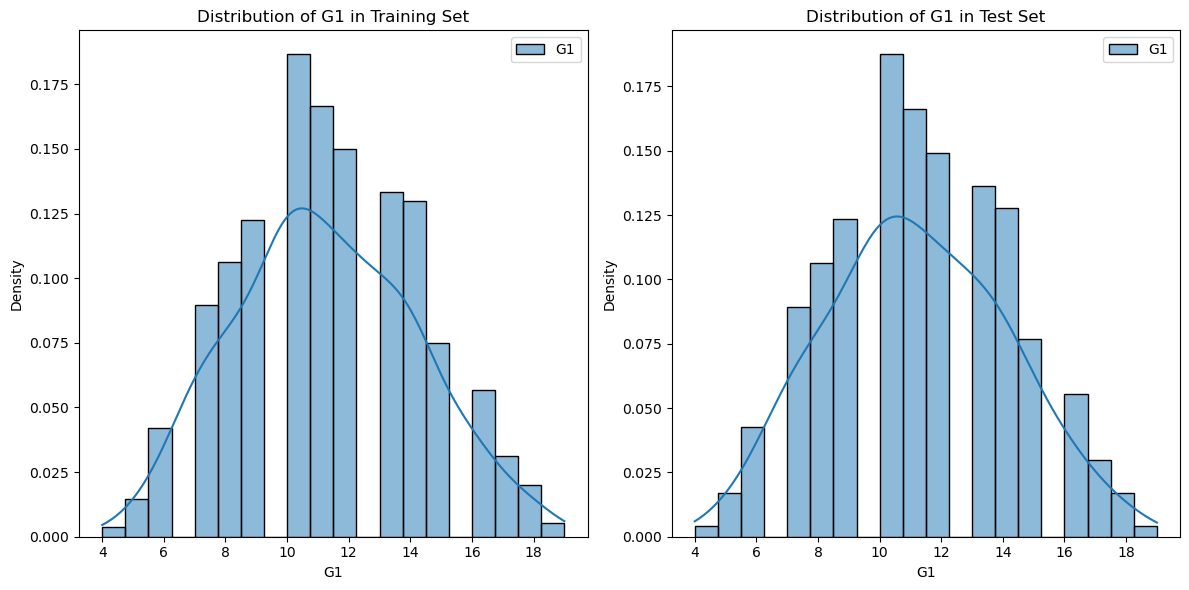

In [32]:
# Remove rows where G1 is not duplicated since stratisfy would be impossible otherwise
merged_num = merged_num[merged_num["G1"].duplicated(keep=False)]
# 2 rows were removed
X_strat = merged_num.drop(columns=["G1", "G2", "G3", "G1_G3_diff", "G1_G2_diff"])
y_strat = merged_num[["G1"]]

X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(X_strat, (y_strat[y_strat["G1"].duplicated(keep=False)]), test_size=0.30, random_state=1, stratify=(y_strat[y_strat["G1"].duplicated(keep=False)]["G1"]))

# Histogram chart of G1 in y_train and y_test
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_train_strat, bins=20, kde=True, stat="density")
plt.title("Distribution of G1 in Training Set")
plt.xlabel("G1")
plt.ylabel("Density")
plt.subplot(1, 2, 2)
sns.histplot(y_test_strat, bins=20, kde=True, stat="density")
plt.title("Distribution of G1 in Test Set")
plt.xlabel("G1")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


Ah, this looks better

Let's try retraining the aforementioned models on scaled data as some models benefited from that in comparison to the unscaled data

In [33]:
# Fit on training data or else we have data leakage
scaler_strat = preprocessing.StandardScaler().fit(X_train_strat)
X_train_scaled_strat = scaler_strat.transform(X_train_strat)
X_test_scaled_strat = scaler.transform(X_test_strat)

In [34]:
models_strat = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "Neural Net": MLPRegressor(), # Add regularization
    "Bayesian Ridge Regression": BayesianRidge(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Support Vector Regression": SVR()
}

# Evaluate models on the original data
results_scaled_strat, predictions_scaled_strat = evaluate_models(models_strat, X_train_scaled_strat, y_train_strat, X_test_scaled_strat, y_test_strat)


/opt/anaconda3/envs/education/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
results_scaled_strat.sort_values(by="RMSE Test", ascending=True).round(2)

,RMSE Train,MAE Train,R2 Train,MAE Test,RMSE Test,R2 Test
Random Forest,0.95,0.68,0.90,1.86,2.38,0.35
Gradient Boosting Regressor,1.85,1.43,0.61,1.95,2.49,0.28
Support Vector Regression,2.08,1.45,0.50,2.00,2.55,0.25
Bayesian Ridge Regression,2.45,1.93,0.32,2.02,2.58,0.23
Linear Regression,2.45,1.92,0.32,2.06,2.60,0.22
Neural Net,1.60,1.25,0.71,2.10,2.62,0.21
XGBoost,0.08,0.01,1.00,2.15,2.71,0.15
Decision Tree Regressor,0.00,0.00,1.00,2.68,3.45,-0.37


In [36]:
# Difference between original and stratified results
performance_diff_strat = calculate_performance_difference(results_scaled, results_scaled_strat)
performance_diff_strat.sort_values(by="RMSE Difference", ascending=True).round(2)

,RMSE Difference,MAE Difference,R2 Difference
XGBoost,-0.08,-0.19,-0.07


### Observation

Most models benefited from the stratisfied sampling, only the XGBoost and NN struggled.

Let us try down-sampling and/or up-sampling to see if we enhance our performances even more

## Down- and up-sampling

### Down-sampling

We will try out 3 approaches:
1. Stratisfied sampling and then downsampling the training set (Thus, we can try to get rid of biases during training)
2. Downsampling whole dataset, no Stratisfied sampling (Less bias in total)
3. Downsampling whole dataset + Stratisfied sampling (Less bias but equal distribution)

#### Approach 1
We apply Down-sampling onto the training set of the stratisfied split so that our test data still represents reality while we try to counteract overfitting onto the most frequent grade during training.

In [37]:
# Downsample grades 10-12 to 70% of the train data (as 70% made the relativ frequency of grades 7-14 quite similar)
def downsample_grades(df, grades, fraction=0.7):
    downsampled = df[df["G1"].isin(grades)].sample(frac=fraction, random_state=1)
    return pd.concat([df[~df["G1"].isin(grades)], downsampled])

# We use the already stratisifed split data as input to downsample our data
grades_to_downsample = [10, 11, 12]
downsampled_data = downsample_grades(pd.concat([X_train_strat, y_train_strat], axis=1), grades_to_downsample)

print(f"Downsampled data shape from {X_train_strat.shape} to {downsampled_data.shape}")
# Split the downsampled data into features and target
X_train_strat_downsampled = downsampled_data.drop(columns=["G1"])
y_train_strat_downsampled = downsampled_data[["G1"]]

# Fit on training data or else we have data leakage
scaler_downsampled = preprocessing.StandardScaler().fit(X_train_strat_downsampled)
X_train_scaled_strat_downsampled = scaler_downsampled.transform(X_train_strat_downsampled)
# Evaluate models on the downsampled data
results_downsampled, predictions_downsampled = evaluate_models(models_strat, X_train_strat_downsampled, y_train_strat_downsampled, X_test_scaled_strat, y_test_strat)
X_train_strat_downsampled

/opt/anaconda3/envs/education/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/education/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Downsampled data shape from (729, 44) to (646, 45)


/opt/anaconda3/envs/education/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/education/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/education/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/education/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BayesianRidge was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/education/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
708,0,0,18,0,0,1,1,1,2,2,...,1,0,0,0,1,0,0,0,1,0
925,1,1,17,0,1,1,3,3,1,1,...,0,1,0,0,1,0,0,0,1,0
371,1,1,18,1,0,1,1,2,3,1,...,0,1,0,0,0,1,0,1,0,0
554,0,0,15,0,1,1,1,2,1,2,...,1,0,0,1,0,0,0,0,1,0
90,0,0,16,0,1,1,3,3,1,3,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,0,1,15,0,1,1,4,4,1,1,...,0,0,0,0,0,1,0,1,0,0
926,1,1,17,0,1,1,1,1,3,2,...,0,1,0,0,0,1,0,0,1,0
619,0,0,19,0,1,1,3,3,1,4,...,1,0,0,0,0,0,1,0,0,1
397,0,0,15,0,0,1,1,1,1,2,...,1,0,0,0,0,1,0,0,1,0


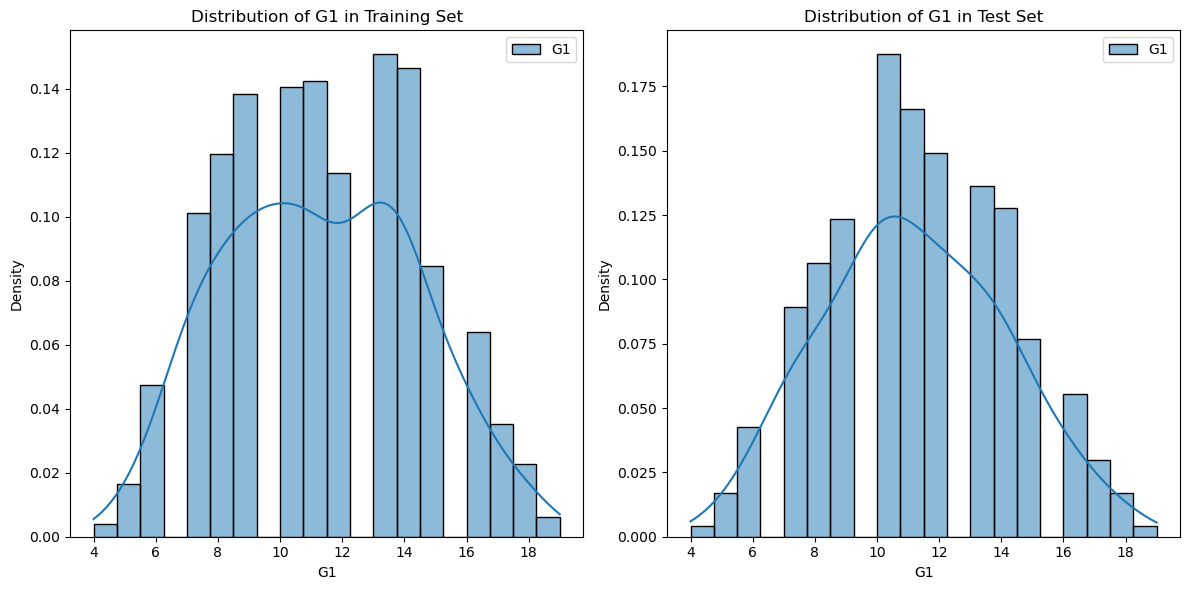

In [38]:
# Histogram chart of G1 in y_train and y_test
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_train_strat_downsampled, bins=20, kde=True, stat="density")
plt.title("Distribution of G1 in Training Set")
plt.xlabel("G1")
plt.ylabel("Density")
plt.subplot(1, 2, 2)
sns.histplot(y_test_strat, bins=20, kde=True, stat="density")
plt.title("Distribution of G1 in Test Set")
plt.xlabel("G1")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [39]:
results_downsampled.sort_values(by="RMSE Test", ascending=True).round(2)

,RMSE Train,MAE Train,R2 Train,MAE Test,RMSE Test,R2 Test
Support Vector Regression,2.78,2.22,0.21,2.25,2.84,0.07
XGBoost,0.07,0.00,1.00,2.48,3.02,-0.06
Random Forest,1.04,0.75,0.89,2.43,3.05,-0.08
Gradient Boosting Regressor,1.90,1.47,0.63,2.69,3.35,-0.29
Decision Tree Regressor,0.00,0.00,1.00,3.04,3.82,-0.68
Bayesian Ridge Regression,2.54,2.02,0.34,3.30,4.02,-0.87
Linear Regression,2.51,2.00,0.35,4.03,4.96,-1.84
Neural Net,2.39,1.89,0.41,10.71,11.08,-13.17


In [40]:
# Calculate the difference between the original data performance and the downsampled data for each model
performance_diff_downsampled = calculate_performance_difference(results_scaled, results_downsampled)
performance_diff_downsampled.sort_values(by="RMSE Difference", ascending=True).round(2)

,RMSE Difference,MAE Difference,R2 Difference
XGBoost,-0.4,-0.51,-0.28


##### Observation

From down sampling we lost 86 data points. All models' performance majorly suffered from splitting in a stratisfied fashion and then downsampling the training data. This is most likely due to the distribution of the two sets being so different. We doubt that the loss in data points is deciding as the reduction is training size is unproportional to the performance loss.

#### Approach 2

We apply downsampling on the whole dataset and then split. This way we decrease the prominence of the majority class in the hope of gaining a more generizable model and retain a more similar distribution over both sets which we assumed to be the main problem in approach 1 (we do not apply stratisfied sampling yet though).

In [41]:
# Downsample grades 10-12 to 10% of the original data
grades_to_downsample = [10, 11, 12]
downsampled_data_2 = downsample_grades(merged_num, grades_to_downsample)
# Split the downsampled data into features and target
X_downsampled_2 = downsampled_data_2.drop(columns=["G1", "G2", "G3", "G1_G3_diff", "G1_G2_diff"])
y_downsampled_2 = downsampled_data_2[["G1"]]
print(f"Downsampled data shape: {X_downsampled_2.shape}")
# Split the downsampled data into training and test sets
X_train_downsampled_2, X_test_downsampled_2, y_train_downsampled_2, y_test_downsampled_2 = train_test_split(X_downsampled_2, y_downsampled_2, test_size=0.30, random_state=1)
# Fit on training data or else we have data leakage
scaler_downsampled_2 = preprocessing.StandardScaler().fit(X_train_downsampled_2)
X_train_scaled_downsampled_2 = scaler_downsampled_2.transform(X_train_downsampled_2)
X_test_scaled_downsampled_2 = scaler_downsampled_2.transform(X_test_downsampled_2)
# Evaluate models on the downsampled data
results_downsampled_2, predictions_downsampled_2 = evaluate_models(models_strat, X_train_scaled_downsampled_2, y_train_downsampled_2, X_test_scaled_downsampled_2, y_test_downsampled_2)

Downsampled data shape: (924, 44)


/opt/anaconda3/envs/education/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


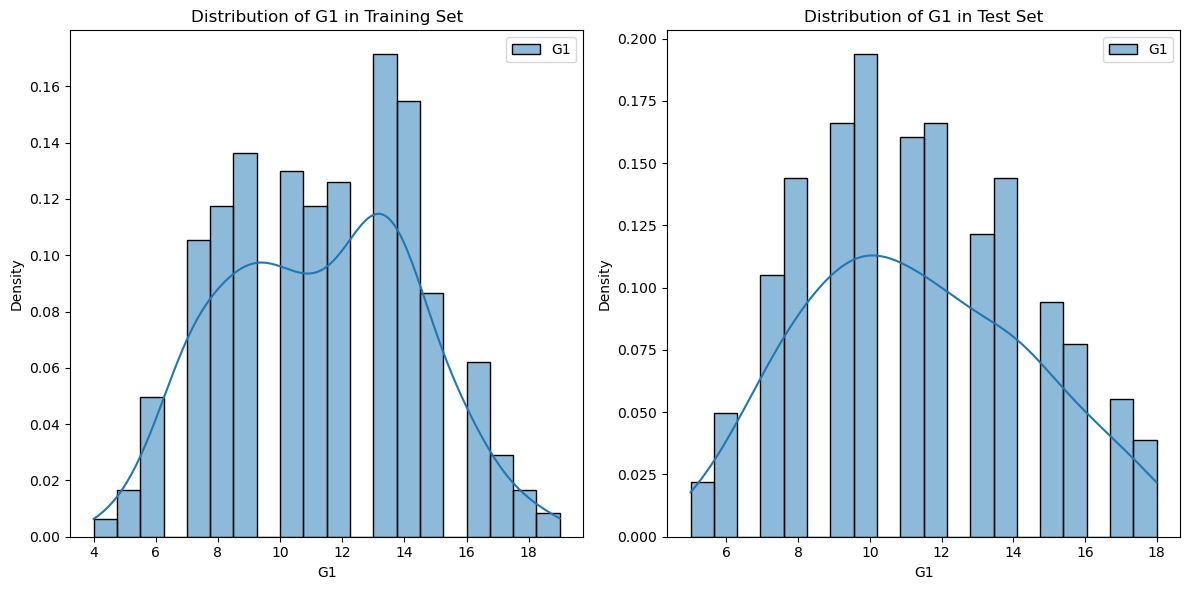

In [42]:
# Histogram chart of G1 in y_train and y_test
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_train_downsampled_2, bins=20, kde=True, stat="density")
plt.title("Distribution of G1 in Training Set")
plt.xlabel("G1")
plt.ylabel("Density")
plt.subplot(1, 2, 2)
sns.histplot(y_test_downsampled_2, bins=20, kde=True, stat="density")
plt.title("Distribution of G1 in Test Set")
plt.xlabel("G1")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [43]:
results_downsampled_2.sort_values(by="RMSE Test", ascending=True).round(2)

,RMSE Train,MAE Train,R2 Train,MAE Test,RMSE Test,R2 Test
Random Forest,1.02,0.72,0.89,1.96,2.49,0.37
Gradient Boosting Regressor,1.91,1.46,0.62,2.04,2.59,0.32
XGBoost,0.00,0.00,1.00,2.04,2.60,0.31
Linear Regression,2.56,2.04,0.32,2.12,2.63,0.29
Neural Net,1.75,1.33,0.69,2.08,2.64,0.29
Bayesian Ridge Regression,2.57,2.03,0.32,2.12,2.65,0.28
Support Vector Regression,2.20,1.57,0.50,2.11,2.65,0.28
Decision Tree Regressor,0.00,0.00,1.00,2.94,3.72,-0.42


In [44]:
# Calculate the difference between the original data performance and the downsampled data for each model
performance_diff_downsampled_2 = calculate_performance_difference(results_scaled, results_downsampled_2)
performance_diff_downsampled_2.sort_values(by="RMSE Difference", ascending=True).round(2)

,RMSE Difference,MAE Difference,R2 Difference
XGBoost,0.02,-0.07,0.08


##### Observations
By down-sampling we lost 159 data points. This had major negative impact on all performance metrics. Only the R^2 benefited here and there. This could mean that the models aren't mainly predicting the average. Since we decreased the count of these "majority classes" we were able to explain more of the variance. Thus, the models more accurately learned the grades' underlying patterns from the features. So, even though RMSE decreased, it does not mean that this approach is not suitable. On the contrary, it might mean that this approach goes into the correct direction. Also, all tree-based models performed the best with the exception of DTR.

#### Approach 3
But maybe we can increase RMSE and MAE when applying stratisfied sampling additionally? Let's see:

In [45]:
# Split the downsampled data into training and test sets
X_train_downsampled_strat, X_test_downsampled_strat, y_train_downsampled_strat, y_test_downsampled_strat = train_test_split(X_downsampled_2, y_downsampled_2, test_size=0.30, random_state=1, stratify=y_downsampled_2["G1"])
# Fit on training data or else we have data leakage
scaler_downsampled_strat = preprocessing.StandardScaler().fit(X_train_downsampled_strat)
X_train_scaled_downsampled_strat = scaler_downsampled_strat.transform(X_train_downsampled_strat)
X_test_scaled_downsampled_strat = scaler_downsampled_strat.transform(X_test_downsampled_strat)
# Evaluate models on the downsampled data
results_downsampled_strat, predictions_downsampled_strat = evaluate_models(models_strat, X_train_scaled_downsampled_strat, y_train_downsampled_strat, X_test_scaled_downsampled_strat, y_test_downsampled_strat)

/opt/anaconda3/envs/education/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


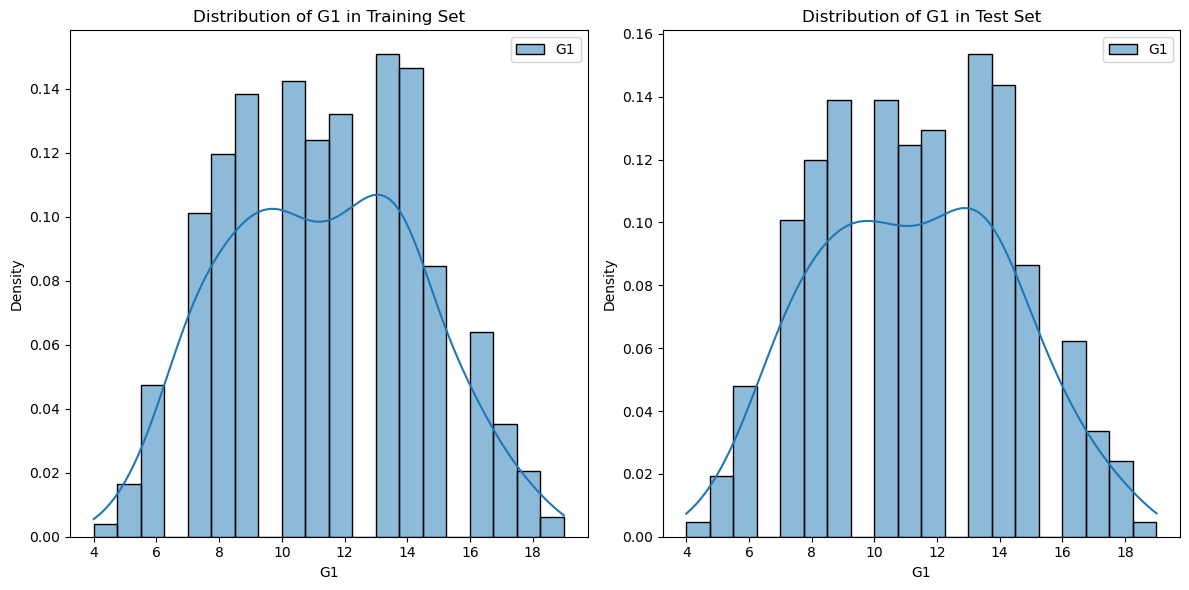

In [46]:
# Histogram chart of G1 in y_train and y_test
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_train_downsampled_strat, bins=20, kde=True, stat="density")
plt.title("Distribution of G1 in Training Set")
plt.xlabel("G1")
plt.ylabel("Density")
plt.subplot(1, 2, 2)
sns.histplot(y_test_downsampled_strat, bins=20, kde=True, stat="density")
plt.title("Distribution of G1 in Test Set")
plt.xlabel("G1")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [47]:
# Here we compare it with the results of approach 2, not the performance on the purely scaled data
performance_diff_downsampled = calculate_performance_difference(results_downsampled_2, results_downsampled_strat)
performance_diff_downsampled.sort_values(by="RMSE Difference", ascending=True).round(2)

,RMSE Difference,MAE Difference,R2 Difference
XGBoost,-0.12,-0.10,-0.06
Random Forest,-0.10,-0.05,-0.05
Linear Regression,-0.08,0.03,-0.04
Bayesian Ridge Regression,-0.02,0.06,-0.01
Support Vector Regression,-0.02,0.01,-0.01
Gradient Boosting Regressor,-0.01,0.04,-0.00
Neural Net,0.03,0.09,0.02
Decision Tree Regressor,0.23,0.26,0.18


#### Observations

Against out intuition, adding stratisfied sampling next to down-sampling slightly worsened the performance. However, this approach is still better than only downsampling the training data. Only the DTR benefited from it but its results are far too sub-par as to recognize its deltas as meaningful indicators.

### Take-away

Downsampling the whole dataset without applying Stratisfied sampling (approach nr. 2) yielded the best performance of all of the down-sampling methods. Specifically, R^2 improved in to contrast to applying no downsampling. However, metrics like RMSE and MAE worsened. Viewing the metric performance deviations in relative terms, the increase in R^2 comes out on top for the XGBoost, BRR, RFR and LR. Therefore, we see downsampling the whole dataset without applying stratisfied sampling as a valid approach for these models. 


### Up-sampling

Let's see what happens when we upsample some values. We can't proceed in the same fashion as for down-sampling since up-sampling the whole dataset would skew the test set and thus the test set would not be able to be seen as the ground truth anymore which contradicts core principals of machine learning. Consequently, we only apply up-sampling on the training data with stratisfied sampling.

In [48]:
# Upsample grades 15-17 and 5-7 to 10% of the original data using SMOTE
def upsample_grades(df, grades, fraction=0.1):
    smote = SMOTE(sampling_strategy={grade: int(fraction * len(df)) for grade in grades}, random_state=1)
    X = df.drop(columns=["G1"])
    y = df["G1"]
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return pd.concat([X_resampled, y_resampled], axis=1)

# We use the already stratisifed split data as input to upsample our data
grades_to_upsample = [15, 16, 17, 5, 6, 7]
upsampled_data = upsample_grades(pd.concat([X_train_strat, y_train_strat], axis=1), grades_to_upsample)
print(f"Upsampled data shape from {X_train_strat.shape} to {upsampled_data.shape}")
# Split the upsampled data into features and target
X_train_strat_upsampled = upsampled_data.drop(columns=["G1"])
y_train_strat_upsampled = upsampled_data[["G1"]]
# Fit on training data or else we have data leakage
scaler_upsampled = preprocessing.StandardScaler().fit(X_train_strat_upsampled)
X_train_scaled_strat_upsampled = scaler_upsampled.transform(X_train_strat_upsampled)
# Evaluate models on the upsampled data
results_upsampled, predictions_upsampled = evaluate_models(models_strat, X_train_scaled_strat_upsampled, y_train_strat_upsampled, X_test_scaled_strat, y_test_strat)


Upsampled data shape from (729, 44) to (992, 45)


/opt/anaconda3/envs/education/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


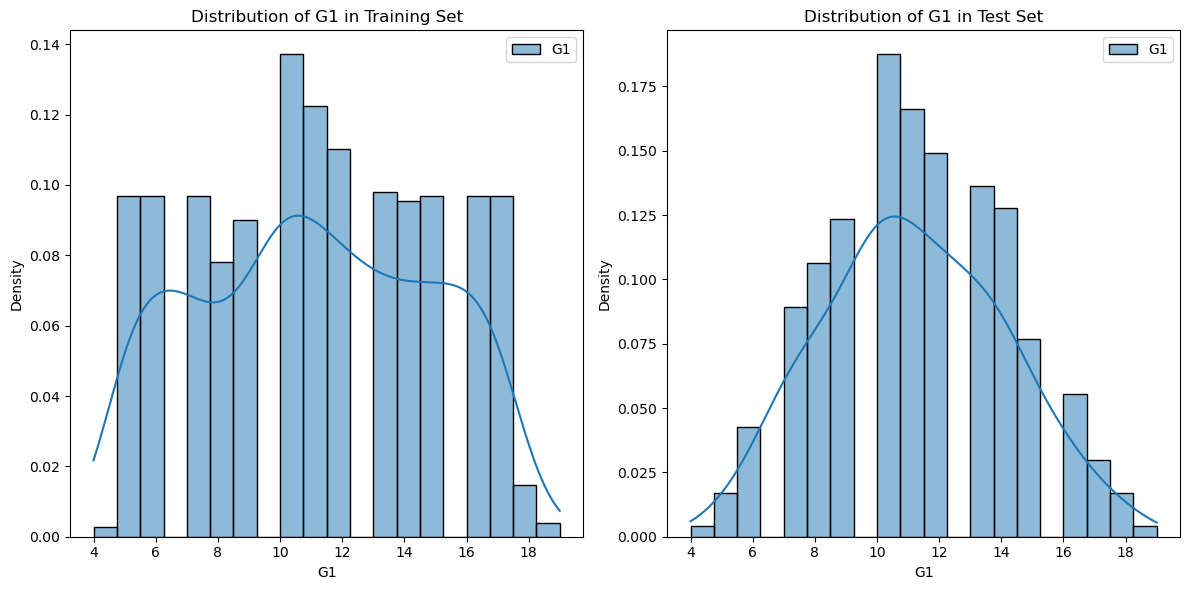

In [49]:
# Histogram chart of G1 in y_train and y_test
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_train_strat_upsampled, bins=20, kde=True, stat="density")
plt.title("Distribution of G1 in Training Set")
plt.xlabel("G1")
plt.ylabel("Density")
plt.subplot(1, 2, 2)
sns.histplot(y_test_strat, bins=20, kde=True, stat="density")
plt.title("Distribution of G1 in Test Set")
plt.xlabel("G1")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [50]:
results_upsampled.sort_values(by="RMSE Test", ascending=True).round(2)

,RMSE Train,MAE Train,R2 Train,MAE Test,RMSE Test,R2 Test
Random Forest,0.90,0.60,0.94,1.98,2.52,0.26
Gradient Boosting Regressor,2.03,1.60,0.70,1.98,2.53,0.26
Support Vector Regression,2.21,1.56,0.65,2.04,2.62,0.21
Neural Net,1.71,1.30,0.79,2.19,2.74,0.13
Bayesian Ridge Regression,2.78,2.27,0.44,2.16,2.74,0.13
Linear Regression,2.78,2.27,0.44,2.21,2.82,0.08
Decision Tree Regressor,0.00,0.00,1.00,2.97,3.78,-0.65
XGBoost,0.13,0.02,1.00,4.24,5.08,-1.98


In [51]:
# Calculate the difference between the original data performance and the downsampled data for each model
performance_diff_upsampled = calculate_performance_difference(results_scaled, results_upsampled)
performance_diff_upsampled.sort_values(by="RMSE Difference", ascending=True).round(2)

,RMSE Difference,MAE Difference,R2 Difference
XGBoost,-2.45,-2.27,-2.2


##### Observation
We added 263 data points over 6 grades to the training data. Performance did not increase, it slightly to moderately suffered. Possibly the synthetically added data is too distant from the actual entries, confusing the model. I'ts remarkable how stabil the RF stays, dispite some grades being up-sampled up to a magitude of 5x.

### Take-away

Down-sampling had some benefits whereas up-sampling did not. Therefore, we will use the data split from Approach 2 for the rest of our work

## Hyperparameter tuning

Initially, we only wanted to tune one model, however, considering that XGBoost and RF have comparable performance considering that the former was completly overfitting, we thought it would be unsuitable to ignore it.

We use Bayesian Optimization from the library hyperopt to balance exploration and exploitation of the search space. Bayesian Optimization is a state-of-the-art method in finding hyperparameters. It builds a surrogate for the objective, quantifies its uncertainity with a Gaussian process regression to finally find the most suitable sample of parameters. (Frazier, 2018, p.255) More information can be found in the paper of Frazier (2018).

### Tuning XGBoost

In [52]:
# Define the hyperparameter space
space = {
    'max_depth': hp.choice('max_depth', np.arange(1, 100, dtype=int)),
    'eta': hp.uniform('eta', 0, 1),
    # 'subsample': hp.uniform('subsample', 0.5, 1), # See XGBoost documentation why subsample >= 0.5
    'max_leaves': hp.choice('max_leaves', np.arange(1, 100, dtype=int)),
    'alpha': hp.uniform('alpha', 0, 5),
    'lambda': hp.uniform('lambda', 0, 5),
    'max_delta_step': hp.uniform('max_delta_step', 0, 5),
    'min_child_weight': hp.uniform('min_child_weight', 1, 100),
    'gamma': hp.uniform('gamma', 0, 20),
    'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0, 1),
    'colsample_bynode': hp.uniform('colsample_bynode', 0, 1),
}

# Define the objective function to minimize
def objective(params):
    global y_pred_xg, xgb_model
    xgb_model = XGBRegressor(**params, random_state=1)
    xgb_model.fit(X_train_downsampled_2, y_train_downsampled_2)
    y_pred_xg = xgb_model.predict(X_test_downsampled_2).round(0)
    score = root_mean_squared_error(y_test_downsampled_2, y_pred_xg)
    # score = r2_score(y_test_downsampled_2, y_pred)
    # return r2 score as loss
    # print(f"Current score: {score}")
    # print(f"Current r2 score: {score}")

    return {'loss': score, 'status': STATUS_OK}

# Perform the optimization
best_params_xgb = fmin(objective, space, algo=tpe.suggest, max_evals=5000)
print("Best set of hyperparameters: ", best_params_xgb)

100%|██████████| 5000/5000 [05:52<00:00, 14.18trial/s, best loss: 2.388521671295166] 
Best set of hyperparameters:  {'alpha': np.float64(0.2364006566150296), 'colsample_bylevel': np.float64(0.9802465492891798), 'colsample_bynode': np.float64(0.1686600241460226), 'colsample_bytree': np.float64(0.9029816780730318), 'eta': np.float64(0.10536850253267507), 'gamma': np.float64(1.5192714505810583), 'lambda': np.float64(3.072837997950418), 'max_delta_step': np.float64(4.001740301032966), 'max_depth': np.int64(53), 'max_leaves': np.int64(57), 'min_child_weight': np.float64(2.8103330794307286)}


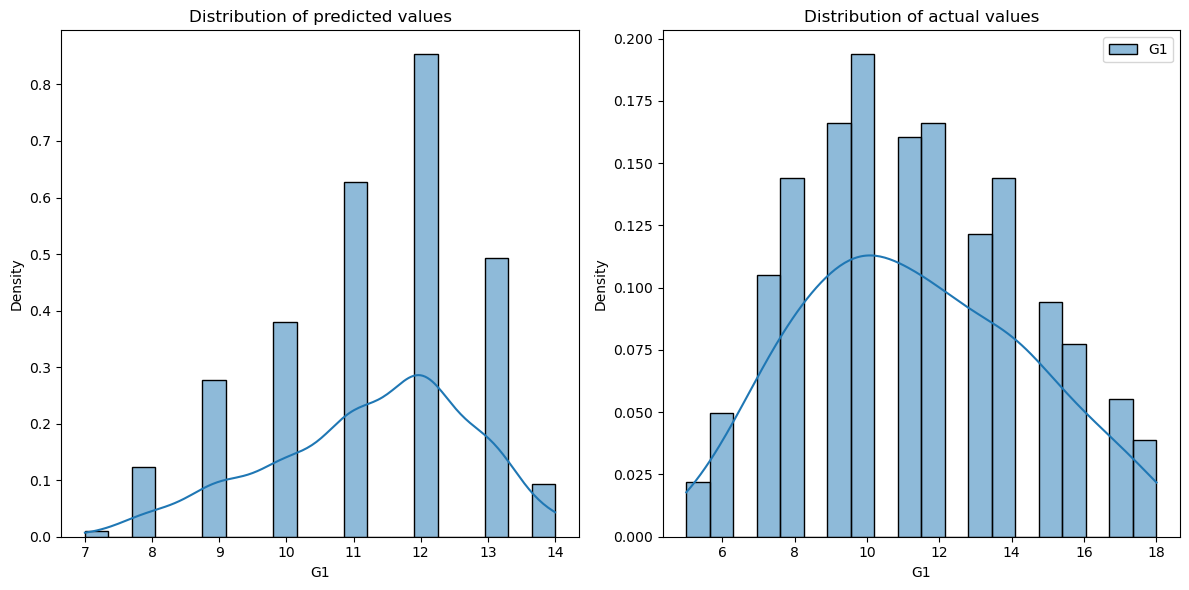

In [53]:
# Histogram chart of G1 in y_train and y_test
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_pred_xg, bins=20, kde=True, stat="density")
plt.title("Distribution of predicted values")
plt.xlabel("G1")
plt.ylabel("Density")
plt.subplot(1, 2, 2)
sns.histplot(y_test_downsampled_2, bins=20, kde=True, stat="density")
plt.title("Distribution of actual values")
plt.xlabel("G1")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

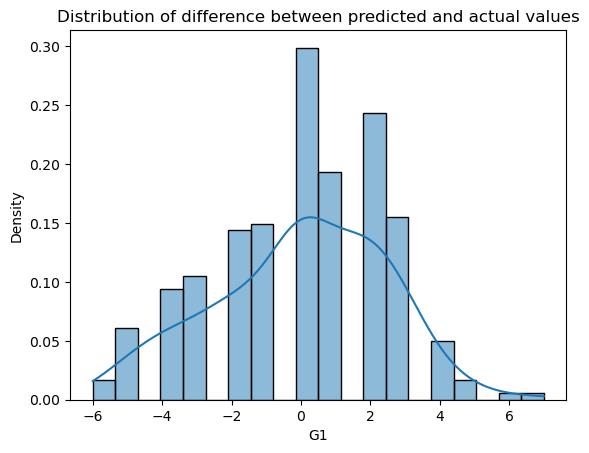

In [54]:
# Calculate difference y_pred_xg - y_test_downsampled_2
diff_xgb = y_pred_xg - y_test_downsampled_2.values.ravel()

sns.histplot(diff_xgb, bins=20, kde=True, stat="density")
plt.title("Distribution of difference between predicted and actual values")
plt.xlabel("G1")
plt.ylabel("Density")
plt.show()

#### Observations

1. The model doesn't predict higher than a score of 15 or lower than 7
2. The model is skewed to predict a score of 11 and 12.
3. Around 30% of the predictions are perfectly accurate. 
4. Due low amount of students getting grades at either end of the scale, most error are between -4 and +2. 

In [55]:
# Compare Default vs tuned hyperparamters
default_xgb = {
    'max_depth': 6,
    'eta': 0.3,
    # 'subsample': hp.uniform('subsample', 0.5, 1), # See XGBoost documentation why subsample >= 0.5
    'max_leaves': 0,
    'alpha': 0,
    'lambda': 1,
    'max_delta_step': 0,
    'min_child_weight': 1,
    'gamma': 0,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
}

### Following code snippet taken from the practical sample submission

# Combine into a DataFrame
param_comparison_df = pd.DataFrame({
    "Hyperparameter": list(default_xgb.keys()),
    "Before Tuning": [default_xgb[k] for k in default_xgb],
    "After Tuning": [best_params_xgb[k] for k in default_xgb]
})

# Add model scores
scores_df = pd.DataFrame({
    "Metric": ["Test RMSE Score"],
    "Before Tuning": [2.6],  # Provided earlier
    "After Tuning": [2.37],  # Provided from Bayesian Optimization
    "Performance increase": [(1- 2.37/2.6)]  # Difference between the two scores
})

param_comparison_df

,Hyperparameter,Before Tuning,After Tuning
0,max_depth,6.0,53.000000
1,eta,0.3,0.105369
2,max_leaves,0.0,57.000000
3,alpha,0.0,0.236401
4,lambda,1.0,3.072838
5,max_delta_step,0.0,4.001740
6,min_child_weight,1.0,2.810333
7,gamma,0.0,1.519271
8,colsample_bytree,1.0,0.902982
9,colsample_bylevel,1.0,0.980247


In [56]:
scores_df

,Metric,Before Tuning,After Tuning,Performance increase
0,Test RMSE Score,2.6,2.37,0.088462


#### Observations

1. The optimal XGBoost tree was found to have a depth of 88, representing an increase of approximately 1460%. This substantial growth indicates that a shallow tree was insufficient to capture the complex relationships within the data, which aligns with the insights gained from our exploratory data analysis (EDA).

2. The learning rate (‘eta’) was reduced by 66%. While a larger learning rate is typically employed to mitigate overfitting—an issue identified in our earlier results—the reduction suggests that the model approached its optimum more cautiously. Although a smaller learning rate may increase the risk of convergence to local optima, it may also prevent missing the global optimum. Given the complexity of the data patterns, this conservative step size likely reflects a finely tuned set of weights that optimize performance.

3. The parameter ‘max\_leaves’, defining the maximum number of leaves in the tree, was constrained to 78, as opposed to having no maximum (which is represented by zero). Allowing an unlimited number of leaves can lead to overfitting, since each data point could theoretically be isolated. Limiting the tree to 78 leaves effectively clusters the data into discrete partitions, promoting better generalization.

4. Regularization parameters—alpha (L1 regularization) and gamma (L2 regularization)—were increased, with a more substantial rise in L1 regularization. This adjustment is consistent with prior observations of significant overfitting in the default XGBoost model, as regularization penalizes model complexity to improve generalization.

5. The ‘max\_delta\_step’ parameter, which governs the magnitude of each update step and thus the model’s conservativeness, was increased. This change further reinforces the model’s shift toward a more cautious optimization process, consistent with the need to reduce overfitting.

6. Similarly, ‘min\_child\_weight’, representing the minimum sum of instance weights required in a child node, was set to a higher value, further encouraging conservative model growth and mitigating overfitting.

7. The ‘colsample\_\*’ parameters, indicating the fraction of columns considered during tree construction, remained largely unchanged except for ‘colsample\_bynode’. These parameters multiply cumulatively, so effectively only about 24 columns were sampled per split out of 43. The reason for changes in these values—despite the model’s difficulty with PCA-reduced data—is unclear and warrants further investigation.

In summary, the hyperparameter adjustments collectively indicate a trend toward a more conservative model, consistent with the overfitting challenges identified in the default XGBoost configuration.


### Take-away

In summary, the model’s performance can be considered acceptable. Through hyperparameter tuning, we achieved improved generalization, resulting in an approximate 8% increase in performance. Nevertheless, the model falls short in delivering highly precise predictions. Consequently, it primarily serves as an indicator of the expected grade range rather than providing accurate forecasts of high-achieving students, particularly those attaining grades of 15 or above. Overall, the model exhibits a conservative bias, tending to predict lower grades more frequently than higher ones. This tendency may stem from the objective of minimizing RMSE, which can favor predictions that reflect the most common grade distribution, thereby reducing the error metric but limiting predictive granularity at the upper performance spectrum.

### Tuning the RF



#### Tuning setup 1: On the downsampled data

In [57]:
# Define the hyperparameter space
space = {
    'n_estimators': hp.choice('n_estimators', np.arange(1, 200, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(1, 50, dtype=int)),
    'min_samples_split': hp.choice('min_samples_split', np.arange(2, 20, dtype=int)),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 50, dtype=int)),
    'max_features': hp.choice('max_features', np.arange(1, 44, dtype=int)),
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 0.5),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'ccp_alpha': hp.uniform('ccp_alpha', 0, 10),
}

# Define the objective function to minimize
def objective(params):
    global y_pred_rfr_1, RFR_model_1
    RFR_model_1 = RandomForestRegressor(**params, random_state=1)
    # We use the simple stratisfied sampling as this is the best performing RFR
    RFR_model_1.fit(X_train_downsampled_2, y_train_downsampled_2.values.ravel())
    y_pred_rfr_1 = RFR_model_1.predict(X_test_downsampled_2).round(0)
    score = root_mean_squared_error(y_test_downsampled_2, y_pred_rfr_1)
    # score = r2_score(y_test_downsampled_2, y_pred)
    # return r2 score as loss
    # print(f"Current score: {score}")
    # print(f"Current r2 score: {score}")

    return {'loss': score, 'status': STATUS_OK}

# Perform the optimization
best_params_rfr_1 = fmin(objective, space, algo=tpe.suggest, max_evals=5000)
print("Best set of hyperparameters: ", best_params_rfr_1)

100%|██████████| 5000/5000 [07:05<00:00, 11.76trial/s, best loss: 2.451691531760567] 
Best set of hyperparameters:  {'bootstrap': np.int64(1), 'ccp_alpha': np.float64(0.0020766192054736286), 'max_depth': np.int64(22), 'max_features': np.int64(8), 'min_impurity_decrease': np.float64(0.00036246443115052), 'min_samples_leaf': np.int64(0), 'min_samples_split': np.int64(4), 'n_estimators': np.int64(147)}


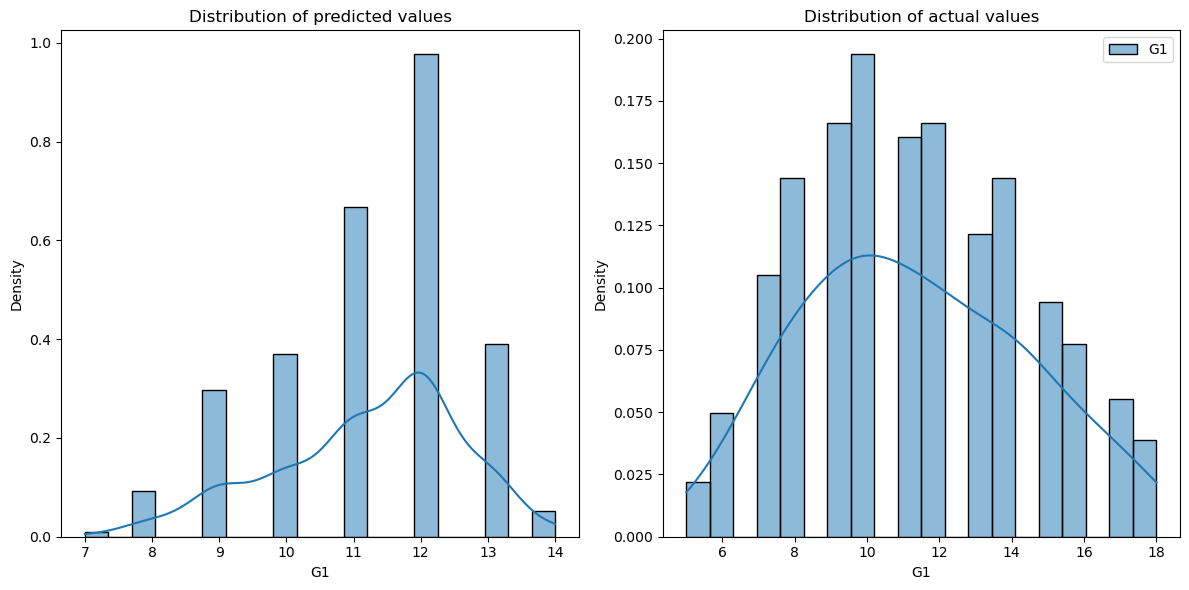

In [58]:
# Histogram chart of G1 in y_train and y_test
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_pred_rfr_1, bins=20, kde=True, stat="density")
plt.title("Distribution of predicted values")
plt.xlabel("G1")
plt.ylabel("Density")
plt.subplot(1, 2, 2)
sns.histplot(y_test_downsampled_2, bins=20, kde=True, stat="density")
plt.title("Distribution of actual values")
plt.xlabel("G1")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

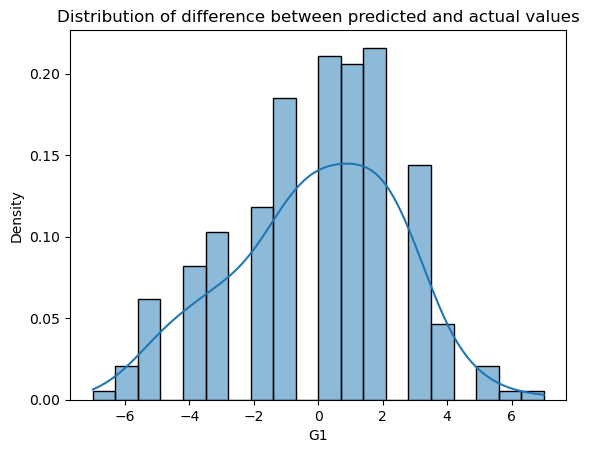

In [59]:
# Calculate difference y_pred_xg - y_test_downsampled_2
diff_rfr_1 = y_pred_rfr_1 - y_test_downsampled_2.values.ravel()

sns.histplot(diff_rfr_1, bins=20, kde=True, stat="density")
plt.title("Distribution of difference between predicted and actual values")
plt.xlabel("G1")
plt.ylabel("Density")
plt.show()

#### Observations
The distribution of differences closely resembles that of our XGBoost model; however, the distribution of predicted values is notably problematic. The model appears to disregard accurate grade prediction, predominantly limiting its output to only two grade categories. Such regression behavior is unsuitable for this application and undermines the characterization of the algorithm as "artificial intelligence."

Subsequently, we will analyze the parameters following the Random Forest tuning on the next data split. This will facilitate a more precise comparison and aid in identifying which parameter settings may have contributed to the observed poor performance.

#### Tuning setup 2: On stratisfied sampling without any other sampling techniques

Although we stated earlier that Downsampling without Stratisfied sampling yielded the most promising results in regards to all metrics, we want to see how far we can decrease the RMSE by using the data set on which the basic RF performed the best in that regard. This dataset was statisfied sampling without any other sampling techniques. Therefore, we will also analysis the performance of the RF on that data 

In [60]:
# Define the hyperparameter space
space = {
    'n_estimators': hp.choice('n_estimators', np.arange(1, 200, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(1, 50, dtype=int)),
    'min_samples_split': hp.choice('min_samples_split', np.arange(2, 20, dtype=int)),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 50, dtype=int)),
    'max_features': hp.choice('max_features', np.arange(1, 44, dtype=int)),
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 0.5),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'ccp_alpha': hp.uniform('ccp_alpha', 0, 10),
}

# Define the objective function to minimize
def objective(params):
    global y_pred_rfr_2, RFR_model_2
    RFR_model_2 = RandomForestRegressor(**params, random_state=1)
    # We use the simple stratisfied sampling as this is the best performing RFR
    RFR_model_2.fit(X_train_scaled_strat, y_train_strat.values.ravel())
    y_pred_rfr_2 = RFR_model_2.predict(X_test_scaled_strat).round(0)
    score = root_mean_squared_error(y_test_strat, y_pred_rfr_2)
    # score = r2_score(y_test_downsampled_2, y_pred)
    # return r2 score as loss
    # print(f"Current score: {score}")
    # print(f"Current r2 score: {score}")

    return {'loss': score, 'status': STATUS_OK}

# Perform the optimization
best_params_rfr_2 = fmin(objective, space, algo=tpe.suggest, max_evals=5000)
print("Best set of hyperparameters: ", best_params_rfr_2)

100%|██████████| 5000/5000 [08:21<00:00,  9.97trial/s, best loss: 2.3591301803138656]
Best set of hyperparameters:  {'bootstrap': np.int64(0), 'ccp_alpha': np.float64(0.0002352535412370181), 'max_depth': np.int64(35), 'max_features': np.int64(30), 'min_impurity_decrease': np.float64(0.0007381656321825801), 'min_samples_leaf': np.int64(0), 'min_samples_split': np.int64(0), 'n_estimators': np.int64(48)}


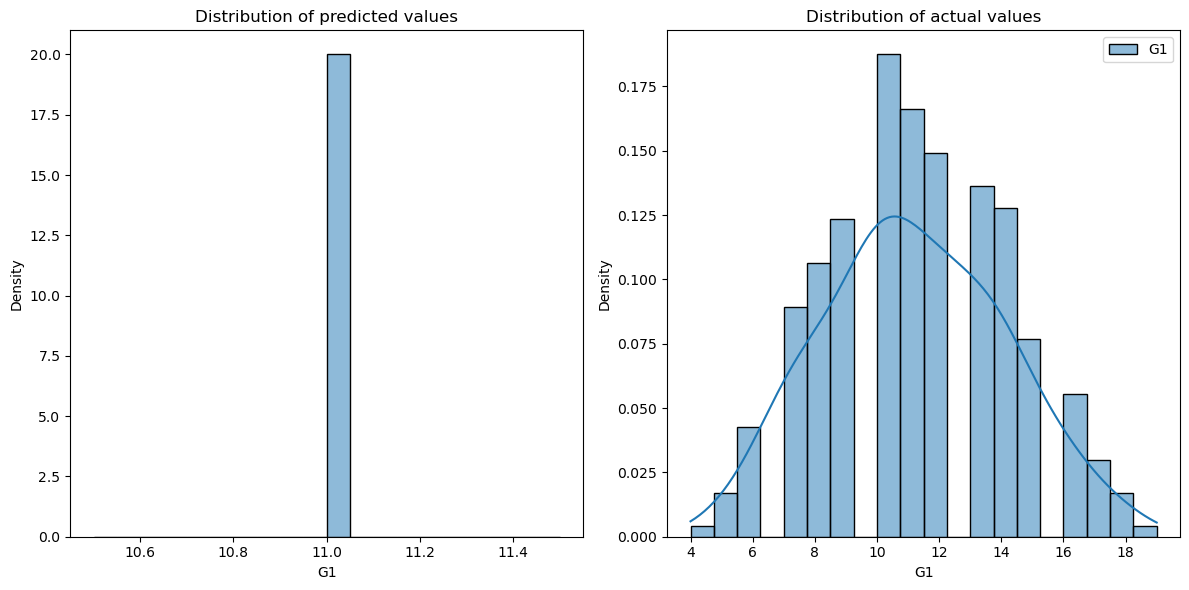

In [61]:
# Histogram chart of G1 in y_train and y_test
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_pred_rfr_2, bins=20, kde=True, stat="density")
plt.title("Distribution of predicted values")
plt.xlabel("G1")
plt.ylabel("Density")
plt.subplot(1, 2, 2)
sns.histplot(y_test_strat, bins=20, kde=True, stat="density")
plt.title("Distribution of actual values")
plt.xlabel("G1")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [62]:
### Following code snippet inspired from the practical sample submission
# Compare Default vs tuned hyperparamters
default_rf = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 1,
    'min_impurity_decrease': 0,
    'bootstrap': True,
    'ccp_alpha': 0,
}

# Combine into a DataFrame
param_comparison_df_rf_2 = pd.DataFrame({
    "Hyperparameter": list(default_rf.keys()),
    "Before Tuning": [default_rf[k] for k in default_rf],
    "After Tuning stratisfied": [best_params_rfr_2[k] for k in default_rf],
    "After Tuning downsampled": [best_params_rfr_1[k] for k in default_rf]
})

# Downsampled model scores
scores_df_rf_1 = pd.DataFrame({
    "Metric": ["Test RMSE Score"],
    "Before Tuning": [2.51],  # Provided earlier
    "After Tuning": [2.46],  # Provided from Bayesian Optimization
    "Performance increase": [(1- 2.46/2.51)]  # Difference between the two scores
})

# Simple sampling results
scores_df_rf_2 = pd.DataFrame({
    "Metric": ["Test RMSE Score"],
    "Before Tuning": [2.44],  # Provided earlier
    "After Tuning": [2.35],  # Provided from Bayesian Optimization
    "Performance increase": [(1- 2.35/2.44)]  # Difference between the two scores
})

param_comparison_df_rf_2

,Hyperparameter,Before Tuning,After Tuning stratisfied,After Tuning downsampled
0,n_estimators,100,48.000000,147.000000
1,max_depth,None,35.000000,22.000000
2,min_samples_split,2,0.000000,4.000000
3,min_samples_leaf,1,0.000000,0.000000
4,max_features,1,30.000000,8.000000
5,min_impurity_decrease,0,0.000738,0.000362
6,bootstrap,True,0.000000,1.000000
7,ccp_alpha,0,0.000235,0.002077


In [63]:
# Performance of the simply stratisfied sampling
scores_df_rf_2

,Metric,Before Tuning,After Tuning,Performance increase
0,Test RMSE Score,2.44,2.35,0.036885


In [64]:
# Performance of the downsampled data
scores_df_rf_1

,Metric,Before Tuning,After Tuning,Performance increase
0,Test RMSE Score,2.51,2.46,0.01992


### Observations

As previously indicated, it is pertinent to revisit the downsampled dataset to elucidate the poor performance observed, particularly in relation to the model parameters.

1. The model demonstrated superior performance on the simple split dataset, both in absolute terms—reflected by a lower RMSE—and in relative improvement following hyperparameter tuning. This suggests that the simple split dataset is more amenable to the Random Forest (RF) algorithm. Furthermore, the distribution of predicted values more closely aligns with the actual distribution, indicating that the model attempts to predict precise grades for individual students rather than clustering predictions into a limited set of grades.

2. The enhanced accuracy of this model can largely be attributed to the selected hyperparameters. Specifically, the values of max\_depth and max\_features are notably greater in the model trained on the simple stratified dataset, implying that this model captures more complex and nuanced patterns within the data. Given that the optimization framework was consistent across both models, the disparity in performance likely arises from the data itself. It is plausible that downsampling caused the RF model to lose critical information necessary for detecting deeper patterns. The reason why the XGBoost model did not exhibit a similar limitation remains an open question for future investigation.

3. Overall, the RF model trained on the simply stratified dataset constitutes the best performing approach among those evaluated.


### Maximizing R^2 om XGBoost

Out of curiosity and completeness, let's shortly check out what happens if we maximize R^2. We tried 2 setups on the RF and only 1 on the XGBoost, so for fairness let's equalize this.

In [65]:
# Define the hyperparameter space
space = {
    'max_depth': hp.choice('max_depth', np.arange(1, 100, dtype=int)),
    'eta': hp.uniform('eta', 0, 1),
    # 'subsample': hp.uniform('subsample', 0.5, 1), # See XGBoost documentation why subsample >= 0.5
    'max_leaves': hp.choice('max_leaves', np.arange(1, 100, dtype=int)),
    'alpha': hp.uniform('alpha', 0, 5),
    'lambda': hp.uniform('lambda', 0, 5),
    'max_delta_step': hp.uniform('max_delta_step', 0, 5),
    'min_child_weight': hp.uniform('min_child_weight', 1, 100),
    'gamma': hp.uniform('gamma', 0, 20),
    'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0, 1),
    'colsample_bynode': hp.uniform('colsample_bynode', 0, 1),
}

def objective(params):
    global y_pred_xg_r2, xgb_model_r2
    xgb_model_r2 = XGBRegressor(**params, random_state=1)
    xgb_model_r2.fit(X_train_downsampled_2, y_train_downsampled_2)
    y_pred_xg_r2 = xgb_model_r2.predict(X_test_downsampled_2).round(0)
    score = r2_score(y_test_downsampled_2, y_pred_xg_r2)
    # score = r2_score(y_test_downsampled_2, y_pred)
    # return r2 score as loss
    # print(f"Current score: {score}")
    print(f"Current r2 score: {score}")

    return {'loss': -score, 'status': STATUS_OK}


# Perform the optimization
best_params_xgb_r2 = fmin(objective, space, algo=tpe.suggest, max_evals=5000)
print("Best set of hyperparameters: ", best_params_xgb_r2)

Current r2 score: 0.24578315019607544                   
Current r2 score: 0.2166898250579834                    
Current r2 score: 0.10436749458312988                                               
Current r2 score: 0.16476374864578247                                               
Current r2 score: 0.22000426054000854                                               
Current r2 score: 0.2778226137161255                                                
Current r2 score: 0.19275230169296265                                               
Current r2 score: 0.2409956455230713                                               
Current r2 score: 0.2439417839050293                                               
Current r2 score: 0.05686068534851074                                              
Current r2 score: 0.23252540826797485                                               
Current r2 score: 0.2564629912376404                                                
Current r2 score: 0.19717150926589966  

In [66]:
rmse_xg_r2 = root_mean_squared_error(y_test_downsampled_2, xgb_model_r2.predict(X_test_downsampled_2).round(0))
print ("Its RMSE: ", rmse_xg_r2)

Its RMSE:  2.450223922729492


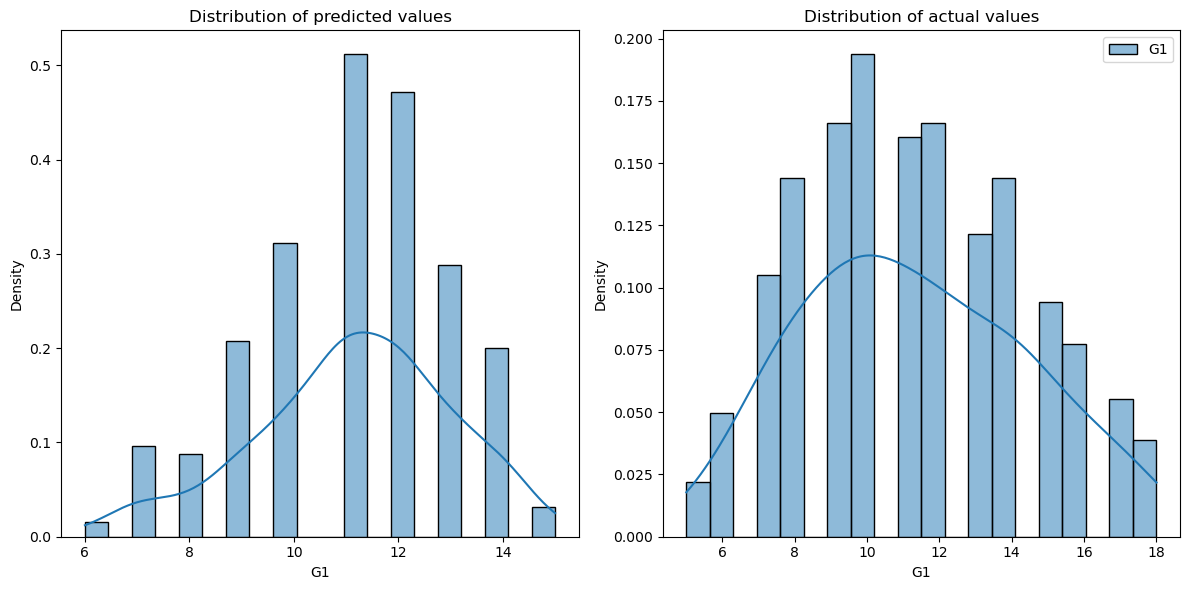

In [67]:
# Histogram chart of G1 in y_train and y_test
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_pred_xg_r2, bins=20, kde=True, stat="density")
plt.title("Distribution of predicted values")
plt.xlabel("G1")
plt.ylabel("Density")
plt.subplot(1, 2, 2)
sns.histplot(y_test_downsampled_2, bins=20, kde=True, stat="density")
plt.title("Distribution of actual values")
plt.xlabel("G1")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

#### Observations

Sadly, this only had a negativ impact. Mainly grade 11 is predicted for all students which is far from the reality. Using RMSE as the loss function / objective returns better results

### Take away

The models performed the best when their parameters enabled to model to build a deep and sophistacted tree. The RF could not create a accurate model on downsampled data, showing its limitations

## Bonus

We didn't want to stop here. We thought that the TabPFN model presented during the exercise class was very interesting. This dataset almost adheres to the various restrictions of the model. Due to its inefficiencies on CPU we did not integrate it into the basic model initializations.
"TabPFN is a learning algorithm that is itself learned across millions of synthetic datasets" (Hollman et al., 2025, p. 319). For more information check out their paper.

In [68]:
model = TabPFNRegressor()

model.fit(X_train_downsampled_2, y_train_downsampled_2.values.ravel())
predictions = model.predict(X_test_downsampled_2)
rmse_test = root_mean_squared_error(y_test_downsampled_2, predictions)
r2_test = r2_score(y_test_downsampled_2, predictions)
print(rmse_test, r2_test)

/opt/anaconda3/envs/education/lib/python3.13/site-packages/tabpfn/regressor.py:460: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


2.7010068893432617 0.2530999779701233


Sadly the TabPFNRegressor doesn't perform that well on our data. In fact, it performs worse than the LR (baseline) on the same data. Possibly the patterns hidden in this dataset don't fit to the learned embeddings of the Regressor.

tabpfn_extensions is used to tune its parameters. However, this is not supported by conda yet so we sadly cannot try it out.

## Conclusion

The objective of this project was to develop a machine learning model capable of accurately predicting a student’s G1 grade based on their social, school, and demographic characteristics. As part of the analysis, we examined the relationships among features and identified complex, nonlinear, and multicollinear interactions. Furthermore, no clear, singular indicators emerged to explain student performance. These challenges were reflected in the machine learning models, all of which initially struggled to achieve a root mean squared error (RMSE) below 2.44 prior to hyperparameter tuning.

A diverse set of models was evaluated, ranging from linear and distance-based algorithms to tree-based methods. Various data preprocessing strategies—including stratified sampling, scaling, principal component analysis (PCA), downsampling, and upsampling—were applied in an effort to enhance model performance. Among these, scaling proved particularly beneficial for distance-based methods such as Support Vector Regression.

Subsequently, the two best-performing models were selected for hyperparameter optimization via Bayesian Optimization, a state-of-the-art and efficient approach, each tested under two different data setups. The Random Forest model trained exclusively on stratified sampling data achieved the best results, attaining an RMSE of 2.35. This outcome underscores the importance of data preparation in achieving good generalization performance.

Additionally, the recently published TabPFN model, which claims superior performance over existing approaches, was evaluated. Unfortunately, it did not meet expectations on our dataset, performing even worse than the baseline model.

Future work could focus on refining up- and down-sampling techniques by experimenting with varying sampling fractions tailored to different grade distributions. Alternatively, feature reduction methods such as correlation-based selection or Feature Agglomeration warrant exploration. Although the Random Forest inherently performs feature selection via Gini index reduction, explicit feature reduction might help mitigate misleading relationships within the data and potentially improve model robustness.


## References


Bergstra, J., Yamins, D., Cox, D. D. (2013) Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures. TProc. of the 30th International Conference on Machine Learning (ICML 2013), June 2013, pp. I-115 to I-23.

Cortez, P. (2008). Student Performance [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5TG7T.


Frazier, P. I. (2018). Bayesian optimization. In Recent advances in optimization and modeling of contemporary problems (pp. 255-278). Informs.

Hollmann, N., Müller, S., Purucker, L. et al. Accurate predictions on small data with a tabular foundation model. Nature 637, 319–326 (2025). https://doi.org/10.1038/s41586-024-08328-6



## Declaration of AI usage



| Tool         | Purpose            | Where?                | Useful? |
|--------------|--------------------|-----------------------|---------|
| ChatGPT 4.0  | Debugging | Throughout | ++      |
| ChatGPT 4.0  | Formatting | Introduction and Declaration | ++      |
| ChatGPT 4.0  | Academic rephrasing | Throughout | ++      |
| ChatGPT 4.0  | Code generation | Section "Basic pre-processing / formatting" | ++      |
| Copilot  | Code completion | Throughout | ++++      |

ChatGPT-chat link: https://chatgpt.com/share/686a6607-40ec-8008-81b5-74531c495e13
